In [48]:
import pickle
import numpy as np
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu,floatX=float32"
import scipy.ndimage
import matplotlib.pyplot as plt
import pymc3 as pm
import math
import networkx as nx
import nxpd

In [2]:
tracks = pickle.load(open("mario_tracks.pkl"))

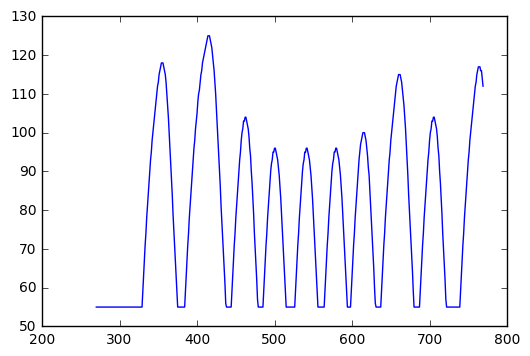

In [3]:

tracksToKeep=['track2']
kept = []
    

for track in sorted(tracks[1]):
    trackID = track[0]
    trackDict = track[1]
    trackDat = []
    for t in sorted(trackDict):
        trackDat.append([t] + list(trackDict[t][1]))
    trackDat = np.array(trackDat)
    if trackID in tracksToKeep:
        kept.append(trackDat)
    #plt.plot(trackDat[:,0],256-trackDat[:,2])
    #plt.show()
    
for trackID in sorted(tracks[0]):
    track = tracks[0][trackID]
    trackDict = track
    trackDat = []
    for t in sorted(trackDict):
        trackDat.append([t] + list(trackDict[t][1]))
    trackDat = np.array(trackDat)
    if trackID in tracksToKeep:
        kept.append(trackDat)
    #plt.plot(trackDat[:,0],256-trackDat[:,2])
    #plt.show()
track = np.vstack(kept)
track = track[:1000,:]
plt.plot(track[:,0],256-track[:,2])
plt.show()


In [4]:
def thresholds(vals, t_window=5):
    last_diff = 0
    last_diff_t = 0
    max_v = min(vals)
    min_v = max(vals)
    thresholds = set([0, min_v, max_v])
    for t, v in enumerate(vals):
        if (t - last_diff_t) == t_window:
            thresholds.add(last_diff)
        if v != last_diff:
            last_diff = v
            last_diff_t = t
    return thresholds

axis = 2
window = 3

velocities = track[1:,axis]-track[:-1,axis] 

thresholds(velocities)

{-4, -3, -2, -1, 0, 4, 5}

In [5]:
def samey_intervals(vals, offset,t_window=5):
    last_diff = 0
    last_diff_t = 0
    intervals = []
    for t, v in enumerate(vals):
        changed = (v != last_diff and (t == len(vals)-1 or vals[t+1] != last_diff))
        if ((t - last_diff_t) >= t_window) and changed:
            intervals.append(last_diff_t)
        if changed:
            last_diff = v
            last_diff_t = t-1
    intervals.append(t-1)
    return sorted(set(intervals))

def val_intervals(vals, value,t_window=5):
    last_diff = -1
    last_diff_t = 0
    intervals = []
    start = 0
    end = 0
    for t,v in enumerate(vals):
        if (v == value and last_diff != value) :
            start = t
        if (v != value and last_diff == value) and (t-start) >= t_window:
            intervals.append(start)
            intervals.append(t-1)
            start = t
        last_diff = v
    return intervals
axis = 2
window = 2

velocities = track[1:,axis]-track[:-1,axis] 
smoothed = scipy.ndimage.filters.convolve1d(velocities, np.ones(window)/window)

print velocities
print samey_intervals(velocities)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3 -3 -2 -3 -2 -2 -2
 -2 -2 -2 -2 -1 -2 -1 -1 -1  0  0  1  1  1  2  3  3  3  4  4  4  4  4  5  4
  4  4  4  4  4  0  0  0  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3 -3
 -3 -2 -3 -2 -2 -3 -2 -1 -2 -2 -1 -2 -1 -1 -1 -1 -1 -1 -1  0  0  1  1  1  2
  2  2  3  3  4  4  4  4  4  4  5  4  4  4  4  4  5  1  0  0  0  0  0  0 -4
 -4 -4 -4 -3 -4 -3 -3 -3 -3 -3 -2 -3 -2 -1 -2  0 -1  0  1  1  1  2  3  2  4
  3  4  4  5  4  4  4  5  2  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3
 -2 -1 -2  0 -1  0  1  1  1  2  2  3  3  4  4  4  4  4  4  4  0  0  0  0  0
  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3 -2 -1 -2  0 -1  0  1  1  1
  2  2  3  3  4  4  4  4  4  4  4  0  0  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4
 -3 -3 -3 -3 -2 -1 -2  0 -1  0  1  1  1  2  2  3  3  4  4  4  4  4  4  4  0
  0  0  0 -4

In [6]:
def zero_crossings(vals):
    sign_intervals = []
    last_sign_change = 0
    vsigns = np.sign(vals)
    last_sign = vsigns[0]
    for t, v in enumerate(vsigns):
        if v == last_sign or (t < len(vsigns) and vsigns[t+1] == last_sign):
            continue
        elif v != last_sign:
            sign_intervals.append(last_sign_change)
            sign_intervals.append(t)
            last_sign = v
            last_sign_change = t
    if t - 1 != last_sign_change:
        sign_intervals.append(last_sign_change)
        sign_intervals.append(t)
    return sorted(set(sign_intervals))

axis = 2
window = 2

velocities = track[1:,axis]-track[:-1,axis] 
print velocities
print zero_crossings(velocities)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3 -3 -2 -3 -2 -2 -2
 -2 -2 -2 -2 -1 -2 -1 -1 -1  0  0  1  1  1  2  3  3  3  4  4  4  4  4  5  4
  4  4  4  4  4  0  0  0  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3 -3
 -3 -2 -3 -2 -2 -3 -2 -1 -2 -2 -1 -2 -1 -1 -1 -1 -1 -1 -1  0  0  1  1  1  2
  2  2  3  3  4  4  4  4  4  4  5  4  4  4  4  4  5  1  0  0  0  0  0  0 -4
 -4 -4 -4 -3 -4 -3 -3 -3 -3 -3 -2 -3 -2 -1 -2  0 -1  0  1  1  1  2  3  2  4
  3  4  4  5  4  4  4  5  2  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3
 -2 -1 -2  0 -1  0  1  1  1  2  2  3  3  4  4  4  4  4  4  4  0  0  0  0  0
  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3 -2 -1 -2  0 -1  0  1  1  1
  2  2  3  3  4  4  4  4  4  4  4  0  0  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4
 -3 -3 -3 -3 -2 -1 -2  0 -1  0  1  1  1  2  2  3  3  4  4  4  4  4  4  4  0
  0  0  0 -4

80


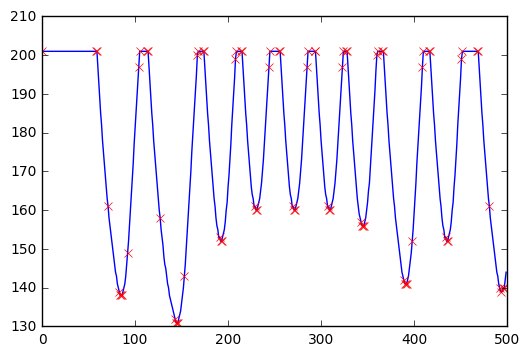

In [7]:
axis = 2

velocities = track[1:,axis]-track[:-1,axis] 

same_window = 8

switch_points = set(zero_crossings(velocities))

samey_points = set(samey_intervals(velocities,t_window=same_window))

velocity_times = sorted(switch_points | samey_points)

print len(velocity_times)

plt.plot(track[:,2])
plt.plot(np.array(velocity_times),track[np.array(velocity_times,dtype='int'),2],'rx')
plt.show()


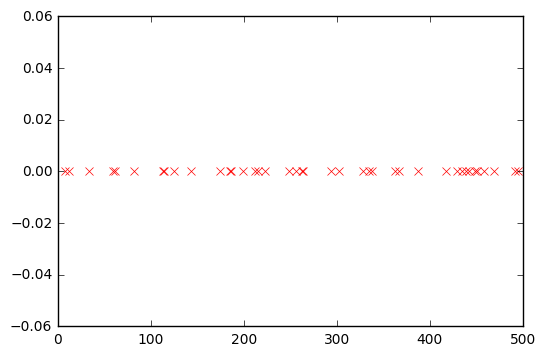

In [8]:
import fceulib
inputVec = fceulib.readInputs('Illustrative.fm2')

def button_change_times(button_masks):
    last_mask = 0
    mask_times = []
    # Note: for a temporary optimization we could drop certain buttons?
    for t, b in enumerate(button_masks):
        if t < track[0,0]:
            continue
        if t > track[-1,0]:
            break
        if b != last_mask:
            mask_times.append(t-track[0,0])
            last_mask = b
    return mask_times

button_times = button_change_times(inputVec)

plt.plot(256-track[:,2])
plt.plot(np.array(button_times),256-track[np.array(button_times),axis],'rx')
plt.show()


In [8]:
# Templates is an array of model-generating functions of increasing complexity.
templates = [
    # Constant 0 velocity
    ("c0",lambda n,axis,vs,pv: pm.Normal(
        n, 
        mu=0,
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Constant velocity from old value
    ("cP",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pv,
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Fixed constant velocity
    ("cN",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pm.Normal(n+"_N",mu=0,sd=10),
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Constant acceleration from 0
    ("acc0",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pm.Normal(n+"_acc",mu=0,sd=10)*vs[:,0],
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Constant acceleration from old velocity value
    ("accP",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pv+pm.Normal(n+"_acc",mu=0,sd=10)*vs[:,0],
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Constant acceleration from fixed constant velocity
    ("accN",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pm.Normal(n+"_N",mu=0,sd=10)+pm.Normal(n+"_acc",mu=0,sd=20)*vs[:,0],
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
]
templates = templates
type2ind = {t[0]:i for i,t in enumerate(templates)}
print type2ind

{'accN': 5, 'cN': 2, 'acc0': 3, 'c0': 0, 'cP': 1, 'accP': 4}


In [9]:
iterations = 5000
from pymc3 import find_MAP
def model_template_generate(template_i, axis, segment, prev_val):
    axisNames = [None,"x","y"]
    template = templates[template_i]
    (tn, t) = template
    with pm.Model() as model:
        lik = t(axisNames[axis],axis,segment,prev_val)
        step = pm.Metropolis()
        trace = pm.sample(iterations, step, progressbar=True, njobs=1, n_init=2000)
        subtrace = trace[len(trace)/2:-1:10]
    return (tn,model,subtrace)

In [10]:
def model_set_generate(data):
    track,all_times,axis,i,j = data
    t0 = all_times[i]
    t1 = all_times[j]
    print "go",i,j,t0,t1
    if t0 == 0:
        segment = track[t0+1:t1+1]-track[t0:t1]
        prev_vel = float('inf')
    elif t1+1 > np.shape(track)[1]:
        extended_track = np.concatenate((track,[track[-1]]))
        segment = extended_track[t0+1:t1+1]-extended_track[t0:t1]
        prev_vel = track[t0,axis]-track[t0-1,axis]
    else:
        #9,10,11 - 8,9,10
        segment = track[t0+1:t1+1]-track[t0:t1]
        prev_vel = track[t0,axis]-track[t0-1,axis]
    segment[:,0] = range(0,np.shape(segment)[0])
    result = map(
        lambda ti: model_template_generate(ti, 
                                           axis,-
                                           segment,
                                           prev_vel),
        range(0,len(templates)))
    return (i,j,t0,t1,result)

In [ ]:
%%time
iterations = 2000
all_times = sorted(set(velocity_times + button_times))
print len(all_times)
all_times = [t for t in all_times if (t>=0 and t < len(velocities))]

likes = [None]*len(all_times)

plt.plot(velocities[:all_times[-1]])
plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
plt.show()

# Takahashi Meijin constant, 60 frames / 16 inputs ~= 4 frames per input.
# But note that in general transitions may happen more frequently due to collisions, etc.
min_interval = 4 

for i in range(0,len(all_times)):
    likes[i] = [None]*len(all_times)
    t0 = all_times[i]
    print t0
    min_likelihood = float('inf')
    for j in [j for j in range(i+1, len(all_times)) if all_times[j]-all_times[i] > min_interval]:
        js = model_set_generate((track,all_times,axis,i,j))
        the_templates = js[-1]
        foundOne = False
        for tn,mod,trace in the_templates:
            logp = -np.mean([mod.logp(pt) for pt in trace])/float(all_times[j]-all_times[i])
            print logp
            if logp < min_likelihood:
                min_likelihood = logp
                foundOne = True
        if not foundOne:
            break
        likes[i][j] = js
        
    #js = map(model_set_generate,
    #         map(lambda j:(track,all_times,axis,i,j), [j for j in range(i+1, len(all_times)) if all_times[j]-all_times[i] > min_interval]))
    #likes[i][i+1:len(all_times)] = js

print "Done!"

In [ ]:
for li in likes[0:10]:
    for lij in li[0:10]:
        if lij is None or lij == []: 
            continue
        (i,j,t0,t1,models) = lij
        print i,j,t0,t1
        for m in models:
            print m[0],pm.df_summary(m[-1])
        print "\n"

In [ ]:
iterations = 5000
all_times = sorted(set(velocity_times + button_times))

all_times = all_times[:100]#[:len(all_times)/4]

In [13]:
# What is the mode as of just before each switch-point, 
# and what is the accumulated cost of the approximation up to that point?
modes = [(0,None)]*(len(all_times))

#modes is offset from likes by 1

ks = {"c0":1, "cP":1, "cN":2, "acc0":2, "accP":2, "accN":3}

cost = 1

# Takahashi Meijin constant, 60 frames / 16 inputs ~= 4 frames per input.
# But note that in general transitions may happen more frequently due to collisions, etc.
min_interval = 4 

for j in range(1, len(all_times)):
    least = float("inf")
    least_template = None
    print "j",j
    for i in range(0, j):
        data = likes[i][j]
        if not data:
            continue
        dt = data[3]-data[2]
        if dt < min_interval:
            print data[:4]
            continue
        the_templates = data[-1]
        print "i",i
        for tn,mod,trace in the_templates:
            k = ks[tn]
            summary = pm.df_summary(trace)
            logp = np.mean([mod.logp(pt) for pt in trace])
            # WAIC
            #crit = -pm.stats.waic(model=mod,trace=trace)
            # DIC
            #crit = pm.stats.dic(model=mod,trace=trace)
            #if np.abs(crit) > 1e5:
            #    crit = float('inf')
            # BPIC
            #crit = pm.stats.bpic(model=mod,trace=trace)
            # AICc
            #crit = 2*k - 2 * logp + (2*(k+1)*(k+2))/(dt-k-2)
            # BIC
            crit = math.log(dt)*k - 2 * logp
            # max-likelihood
            #crit = -logp
            
            #crit = math.log(dt) - logp
            m_prev = modes[i][0]
            # ??
            #crit = summary["mean"]["y_err"]*dt+dt*k
            here = crit + m_prev + math.log(dt)
            print i,j,data[2],data[3],tn,logp,summary["mean"]["y_err"],crit,here,least
            if here < least:
                print "update least",here
                least = here
                # prev_i,this_j,t0,t1,name,summary,criterion
                least_template = (i,j,data[2],data[3],tn,summary,crit)
    modes[j] = (least, least_template)


Points: 100
[0, 8, 12, 33, 58, 59, 61, 71, 82, 83, 84, 85, 86, 92, 104, 105, 113, 114, 125, 127, 143, 144, 145, 146, 153, 167, 168, 173, 174, 185, 186, 191, 192, 193, 199, 208, 209, 212, 214, 215, 223, 229, 230, 231, 244, 245, 248, 255, 256, 262, 264, 270, 271, 272, 285, 286, 293, 294, 302, 308, 309, 310, 323, 324, 327, 328, 335, 338, 343, 344, 345, 346, 360, 361, 362, 366, 367, 387, 389, 390, 391, 392, 398, 409, 410, 416, 417, 429, 434, 435, 436, 439, 442, 448, 451, 452, 458, 468, 469, 481]


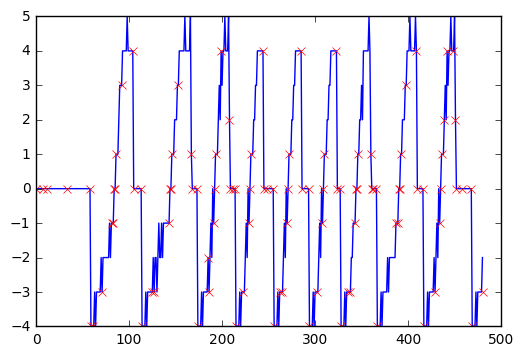

0
go 0 1 0 8


Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 13908.59it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15814.92it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7970.55it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8703.81it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9643.70it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5803.47it/s]


-309.146697818
inf
-36.5308517269
-308.743981722
inf


Applied log-transform to y_err and added transformed y_err_log_ to model.


-22.8645203808
go 0 2 0 12


100%|██████████| 5000/5000 [00:00<00:00, 17005.02it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16247.80it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7642.19it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7966.82it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9878.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5839.27it/s]


-324.083943877
inf
-36.1365450222
-323.816901856
inf


Applied log-transform to y_err and added transformed y_err_log_ to model.


-323.483202936
go 0 3 0 33


100%|██████████| 5000/5000 [00:00<00:00, 16154.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16865.29it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8965.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8895.71it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8963.66it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6177.89it/s]


-343.104136333
inf
-343.007737425
-343.007335688
inf


Applied log-transform to y_err and added transformed y_err_log_ to model.


-26.7852627047
go 0 4 0 58


100%|██████████| 5000/5000 [00:00<00:00, 16136.11it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16037.10it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8956.27it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8700.93it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9408.99it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6200.27it/s]


-347.788302952
inf
-41.7711258713
-347.731699177
inf


Applied log-transform to y_err and added transformed y_err_log_ to model.


-23.8022497667
go 0 5 0 59


100%|██████████| 5000/5000 [00:00<00:00, 17483.19it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16439.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8672.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9202.81it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9168.05it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6128.44it/s]


-347.893798924
inf
-46.337215033
-347.838421413
inf


Applied log-transform to y_err and added transformed y_err_log_ to model.


-30.6557551292
go 0 6 0 61


100%|██████████| 5000/5000 [00:00<00:00, 14452.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16053.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8122.59it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8171.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8212.97it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5726.04it/s]


1.15468750196
inf
1.20114140418
1.16725223715
inf


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.22274018953
8
go 1 3 8 33


100%|██████████| 5000/5000 [00:00<00:00, 16175.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14138.67it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8211.20it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8787.32it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9072.39it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5667.41it/s]


-339.627147538
-339.625517309
-44.1805571201
-339.50024182
-339.495350834


Applied log-transform to y_err and added transformed y_err_log_ to model.


-29.3618379947
go 1 4 8 58


100%|██████████| 5000/5000 [00:00<00:00, 15877.21it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15687.45it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8725.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8805.61it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8607.73it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5983.74it/s]


-346.798211316
-346.799165294
-47.0703906959
-346.734902054
-346.73477254


Applied log-transform to y_err and added transformed y_err_log_ to model.


-28.8148853132
go 1 5 8 59


100%|██████████| 5000/5000 [00:00<00:00, 15713.63it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15512.34it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8899.06it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8433.88it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8072.93it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5429.06it/s]


-346.938122908
-346.938451925
-45.1710236157
-346.876900644
-346.871464555


Applied log-transform to y_err and added transformed y_err_log_ to model.


-22.2369569534
go 1 6 8 61


100%|██████████| 5000/5000 [00:00<00:00, 13956.30it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 13179.64it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6809.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7811.57it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7421.65it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5309.15it/s]


1.23523435031
1.2315822499
1.28500594808
1.24588198248
1.24532919521


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.30786781434
12
go 2 3 12 33


100%|██████████| 5000/5000 [00:00<00:00, 17484.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14238.93it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8491.40it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7953.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8204.64it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6524.90it/s]


-336.893942176
-336.888193749
-43.3742777897
-41.650322741
-39.4632282294


Applied log-transform to y_err and added transformed y_err_log_ to model.


-24.5935861087
go 2 4 12 58


100%|██████████| 5000/5000 [00:00<00:00, 17863.64it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14775.11it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8920.89it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9016.43it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8978.89it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5596.21it/s]


-346.177160443
-346.176604157
-47.1307841952
-346.107019948
-346.105607516


Applied log-transform to y_err and added transformed y_err_log_ to model.


-28.7056368393
go 2 5 12 59


100%|██████████| 5000/5000 [00:00<00:00, 17200.40it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 12946.53it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8533.08it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9148.60it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8472.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5938.17it/s]


-346.339640643
-346.341537908
-42.0733522134
-346.27210631
-346.274216392


Applied log-transform to y_err and added transformed y_err_log_ to model.


-28.0999727573
go 2 6 12 61


100%|██████████| 5000/5000 [00:00<00:00, 16679.57it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16144.97it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8833.53it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9042.52it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9175.58it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6016.93it/s]


1.27631160997
1.2778803855
1.33182166659
1.29386148159
1.29140965478


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.36367531951
33
go 3 4 33 58


100%|██████████| 5000/5000 [00:00<00:00, 17455.67it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 17740.81it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9796.70it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9122.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9008.71it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6270.53it/s]


-339.623174626
-339.627400316
-42.4281679646
-339.498329656
-339.493679354


Applied log-transform to y_err and added transformed y_err_log_ to model.


-28.6818424257
go 3 5 33 59


100%|██████████| 5000/5000 [00:00<00:00, 18220.99it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 17905.35it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8758.81it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9145.00it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9432.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5501.37it/s]


-340.179439237
-340.178199476
-43.2190298852
-340.051345845
-340.054891572


Applied log-transform to y_err and added transformed y_err_log_ to model.


-23.6135617482
go 3 6 33 61


100%|██████████| 5000/5000 [00:00<00:00, 16151.49it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14314.31it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8140.15it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8565.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7827.52it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6254.47it/s]


1.5980608371
1.59999299792
1.69716228808
1.62438726322
1.62247964019


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.74737285441
58
go 4 7 58 71


100%|██████████| 5000/5000 [00:00<00:00, 16562.87it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16200.83it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8675.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9117.12it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8404.73it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6262.50it/s]


2.76185738743
2.76277618025
2.02868554288
2.58296421133
2.58687055421


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.3826461944
go 4 8 58 82


100%|██████████| 5000/5000 [00:00<00:00, 16465.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16914.40it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9520.25it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9184.42it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9117.16it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6430.18it/s]


2.52153979387
2.52370924044
1.75210402301
2.38447295679
2.38515769033


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.74229940197
go 4 9 58 83


100%|██████████| 5000/5000 [00:00<00:00, 16314.60it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15652.00it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8401.13it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8859.39it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8830.52it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5945.67it/s]


2.50315401597
2.50385729333
1.75589950859
2.37614412838
2.37185235379


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.71298626764
go 4 10 58 84


100%|██████████| 5000/5000 [00:00<00:00, 16906.57it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16134.92it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8739.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8800.32it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8536.14it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5876.41it/s]


2.48660892
2.48263303051
1.76474790306
2.36536447255
2.36429368213


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.68077341224
go 4 11 58 85


100%|██████████| 5000/5000 [00:00<00:00, 15561.79it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15896.94it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9217.07it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8837.90it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9085.54it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6115.15it/s]


2.46397193769
2.46322159724
1.81694959205
2.37584391276
2.37722580604


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.67872588147
go 4 12 58 86


100%|██████████| 5000/5000 [00:00<00:00, 15083.28it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16155.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8840.45it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8872.85it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8936.11it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6118.80it/s]


2.4428006679
2.44199773545
1.85574442515
2.37824727179
2.37714190718


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.66578327231
go 4 13 58 92


100%|██████████| 5000/5000 [00:00<00:00, 15770.29it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15984.30it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8607.56it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8441.47it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8813.79it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5942.45it/s]


2.39367126118
2.39655842283
2.27276042697
2.48912084891
2.48625303394


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.7865229227
59
go 5 7 59 71


100%|██████████| 5000/5000 [00:00<00:00, 15457.96it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16273.81it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8892.08it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8633.80it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9142.87it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6251.41it/s]


2.81679042326
2.81867690655
1.57392791281
2.75425270575
2.75061106746


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.36863843194
go 5 8 59 82


100%|██████████| 5000/5000 [00:00<00:00, 16682.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16052.13it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9212.29it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9251.02it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9357.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6433.76it/s]


2.55127026047
2.5569217767
1.63764851837
2.44764704224
2.4439624515


Applied log-transform to y_err and added transformed y_err_log_ to model.


0.91162153658
go 5 9 59 83


100%|██████████| 5000/5000 [00:00<00:00, 16404.47it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16153.67it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8714.31it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8866.73it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8658.22it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5956.29it/s]


2.5271986237
2.52580049577
1.66663624849
2.43065958382
2.42876139184


Applied log-transform to y_err and added transformed y_err_log_ to model.


0.871582178163
go 5 10 59 84


100%|██████████| 5000/5000 [00:00<00:00, 15993.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16074.49it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8552.32it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8438.32it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8692.94it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5986.42it/s]


2.50644220651
2.50931316782
1.68896031669
2.425257982
2.42656853495


Applied log-transform to y_err and added transformed y_err_log_ to model.


0.8311453439
go 5 11 59 85


100%|██████████| 5000/5000 [00:00<00:00, 16374.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15153.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8912.55it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8795.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8833.75it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5990.79it/s]


2.48072887903
2.48516218042
1.76286235183
2.43160308973
2.42794670362


Applied log-transform to y_err and added transformed y_err_log_ to model.


0.890127023765
61
go 6 7 61 71


100%|██████████| 5000/5000 [00:00<00:00, 15515.76it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15861.43it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8638.64it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8547.95it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8435.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5494.74it/s]


2.81642333474
1.73757871558
1.67868377922
2.82583965275
1.17679092493


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.6481131365
go 6 8 61 82


100%|██████████| 5000/5000 [00:00<00:00, 15633.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 13343.55it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8624.27it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8687.02it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8772.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6166.53it/s]


2.51026417218
2.08421234351
1.60062717154
2.41221741637
0.826849323149


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.0063251303
go 6 9 61 83


100%|██████████| 5000/5000 [00:00<00:00, 11067.94it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15555.53it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8843.33it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8772.84it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8577.09it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5904.76it/s]


2.48554309905
2.11802533876
1.62905060593
2.40572718196
0.783082874101


Applied log-transform to y_err and added transformed y_err_log_ to model.


0.950191863119
go 6 10 61 84


100%|██████████| 5000/5000 [00:00<00:00, 15438.97it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15086.87it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8792.91it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8395.75it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7582.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5357.37it/s]


2.46442595375
2.15450926452
1.64751751303
2.3816629441
0.759893769091


Applied log-transform to y_err and added transformed y_err_log_ to model.


0.901439408292
go 6 11 61 85


100%|██████████| 5000/5000 [00:00<00:00, 15077.09it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14361.83it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8119.34it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8392.37it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8178.41it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5681.05it/s]


2.43709042706
2.21475264996
1.72946472252
2.39058051968
0.789886423398


Applied log-transform to y_err and added transformed y_err_log_ to model.


0.965002074453
71
go 7 8 71 82


100%|██████████| 5000/5000 [00:00<00:00, 14899.35it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14177.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7646.30it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8070.41it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7667.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5913.11it/s]


2.33277250788
1.11202143098
1.4460970093
2.35840056518
1.3149095939


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.5267210886
go 7 9 71 83


100%|██████████| 5000/5000 [00:00<00:00, 15429.29it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15986.18it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8936.71it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8740.21it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8804.37it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5976.54it/s]


2.291940962
1.18466435642
1.46627719371
2.31740033031
1.26017303723


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.40302357523
82
go 8 13 82 92


100%|██████████| 5000/5000 [00:00<00:00, 15929.04it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16072.21it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8728.38it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8789.92it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8522.94it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5980.10it/s]


2.19794404037
2.52111948238
2.40946579615
1.83846983697
1.09445980582


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.53406548297
go 8 14 82 104


100%|██████████| 5000/5000 [00:00<00:00, 15087.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15695.73it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8614.50it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8642.85it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8552.18it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5865.89it/s]


2.66800081444
2.90262317536
2.30953420786
1.49976195806
1.62568824158


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.69286567938
83
go 9 13 83 92


100%|██████████| 5000/5000 [00:00<00:00, 16107.94it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15471.54it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8468.42it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8683.95it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8749.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5866.55it/s]


2.25484661421
2.59320617338
2.42761578915
1.66453339738
1.20131650895


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.66428822686
go 9 14 83 104


100%|██████████| 5000/5000 [00:00<00:00, 15500.13it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15727.18it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8429.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8542.61it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8736.71it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5945.90it/s]


2.69605465077
2.92913103219
2.2494596066
1.52028954437
1.76861139946


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.70960520856
84
go 10 13 84 92


100%|██████████| 5000/5000 [00:00<00:00, 15854.25it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15439.25it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9042.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8639.82it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8705.75it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6005.28it/s]


2.32067628982
2.67319214957
2.41217941334
1.42044205319
1.73981848192


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.91926851644
go 10 14 84 104


100%|██████████| 5000/5000 [00:00<00:00, 15591.77it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15628.37it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8583.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8381.40it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8225.97it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5836.46it/s]


2.72855281489
2.96078086922
2.157167872
1.59643070152
1.92565006573


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.68139553803
85
go 11 13 85 92


100%|██████████| 5000/5000 [00:00<00:00, 15755.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16764.30it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8667.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8943.79it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8847.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5951.45it/s]


2.42337342478
2.43470175863
2.47722073463
1.4651088093
1.43517077699


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.13332522386
go 11 14 85 104


100%|██████████| 5000/5000 [00:00<00:00, 15951.87it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16163.61it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8877.40it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9108.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9040.84it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5929.86it/s]


2.75296376606
2.74974637192
2.09164679955
1.73071272796
1.72982407876


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.69865134869
86
go 12 13 86 92


100%|██████████| 5000/5000 [00:00<00:00, 14883.92it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14477.56it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8210.71it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8227.34it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7888.76it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5356.63it/s]


2.56552982155
2.55820976883
2.52339416422
2.01454706267
2.02083208247


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.56349959497
go 12 14 86 104


100%|██████████| 5000/5000 [00:00<00:00, 13870.08it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 13669.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8336.83it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8070.07it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8069.29it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5220.35it/s]


2.78770431182
2.7848645413
1.98404751412
1.88625110371
1.88574669554


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.68086004083
go 12 15 86 105


100%|██████████| 5000/5000 [00:00<00:00, 15876.45it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 13954.32it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8050.21it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8646.88it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7888.64it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5951.87it/s]


2.79260637173
2.7838314866
1.94332191537
1.91457265716
1.91936181743


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.6583653954
go 12 16 86 113


100%|██████████| 5000/5000 [00:00<00:00, 16065.75it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16066.12it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8585.59it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8678.04it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8927.38it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6182.92it/s]


2.58351699103
2.58193821001
2.25120791334
2.54581305351
2.54848710445


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.32594112146
92
go 13 14 92 104


100%|██████████| 5000/5000 [00:00<00:00, 15481.65it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15622.61it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8613.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8621.98it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8673.45it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5883.98it/s]


2.97951212377
1.75787143996
1.17900776351
2.66552804019
1.47465551185


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.5125010261
go 13 15 92 105


100%|██████████| 5000/5000 [00:00<00:00, 15463.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 13650.50it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6768.35it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7847.32it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8342.94it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5758.28it/s]


2.96104832624
1.73675088688
1.10781041752
2.6305453207
1.43516596232


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.404336316
go 13 16 92 113


100%|██████████| 5000/5000 [00:00<00:00, 15332.91it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15679.34it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8714.26it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8640.83it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8813.97it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5908.89it/s]


2.67463601483
2.24681741668
2.40333422561
2.76089955493
2.1967595299


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.1125615781
104
go 14 16 104 113


100%|██████████| 5000/5000 [00:00<00:00, 16025.75it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16192.49it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9126.07it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8872.64it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8823.76it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6282.92it/s]


2.04582775935
2.97670541412
2.4220438011
2.45094104764
2.67920293981


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.78555806437
go 14 17 104 114


100%|██████████| 5000/5000 [00:00<00:00, 15665.34it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16019.58it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8860.47it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9134.27it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8622.45it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5971.07it/s]


1.95276135202
2.95586060522
2.290619184
2.34980273062
2.62360925346


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.60618970586
go 14 18 104 125


100%|██████████| 5000/5000 [00:00<00:00, 15615.53it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15927.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8512.28it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8441.21it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8703.80it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5787.57it/s]


2.51547078448
3.29738505811
2.47731633428
2.0841814029
2.38697358105


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.19988300236
105
go 15 16 105 113


100%|██████████| 5000/5000 [00:00<00:00, 16860.22it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16470.94it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8783.52it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8785.97it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8718.15it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6487.79it/s]


-309.150696746
3.06225621639
-37.4628965284
-37.0467609735
2.99747013333


Applied log-transform to y_err and added transformed y_err_log_ to model.


-26.2795771401
go 15 17 105 114


100%|██████████| 5000/5000 [00:00<00:00, 16682.51it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16748.29it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9415.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9073.39it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9417.79it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6369.15it/s]


-314.123848412
3.03398384497
-41.4122065651
-38.9468874769
2.90933642447


Applied log-transform to y_err and added transformed y_err_log_ to model.


-24.3284636037
go 15 18 105 125


100%|██████████| 5000/5000 [00:00<00:00, 15338.09it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15738.57it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8721.07it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8749.26it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7749.81it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5685.88it/s]


2.49285452523
3.32250569529
2.30999106522
1.88604165366
2.52085374709


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.08874916445
113
go 16 18 113 125


100%|██████████| 5000/5000 [00:00<00:00, 16086.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15195.67it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8659.42it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8867.14it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8299.32it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6022.78it/s]


2.80030920625
2.8067879873
2.06385677058
2.59943843478
2.60079374953


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.45258016553
go 16 19 113 127


100%|██████████| 5000/5000 [00:00<00:00, 16366.56it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15943.17it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8595.41it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7677.53it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7671.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5873.85it/s]


2.75683961663
2.74987232409
1.95916863433
2.55420158797
2.54121483889


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.27165621267
go 16 20 113 143


100%|██████████| 5000/5000 [00:00<00:00, 15229.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15667.15it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8478.34it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8768.25it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8772.47it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6076.88it/s]


2.4426077978
2.44141307475
1.77536841619
2.33625561571
2.33487587115


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.59511203403
go 16 21 113 144


100%|██████████| 5000/5000 [00:00<00:00, 13774.98it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8551.35it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8681.28it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8781.33it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8566.85it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5892.04it/s]


2.42281961604
2.42403830899
1.7678489339
2.3249646399
2.32506163921


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.56976569581
go 16 22 113 145


100%|██████████| 5000/5000 [00:00<00:00, 15963.37it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 13364.34it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9164.98it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9012.39it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8714.66it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6138.86it/s]


2.40503635946
2.4055449902
1.80114241683
2.32779201787
2.3243419494


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.55765605582
go 16 23 113 146


100%|██████████| 5000/5000 [00:00<00:00, 15946.63it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15978.47it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8918.03it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8944.88it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8759.82it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5968.96it/s]


2.38878459504
2.38642037831
1.83115497379
2.32797606937
2.32672380926


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.53931908626
go 16 24 113 153


100%|██████████| 5000/5000 [00:00<00:00, 15829.00it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16215.81it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8745.97it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8799.67it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8620.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5866.65it/s]


2.33838086872
2.33606874944
2.19883426433
2.41462682698
2.41513400635


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.61891222833
114
go 17 18 114 125


100%|██████████| 5000/5000 [00:00<00:00, 16077.07it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16069.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9109.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8933.55it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8873.30it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6523.28it/s]


2.85967638638
2.86052296706
1.4290285052
2.78526212364
2.78118923182


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.36391959081
go 17 19 114 127


100%|██████████| 5000/5000 [00:00<00:00, 15581.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16023.07it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8872.45it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8700.40it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8748.95it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5851.37it/s]


2.79982727266
2.7943806776
1.50048538374
2.69975134404
2.70260266481


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.26670079561
go 17 20 114 143


100%|██████████| 5000/5000 [00:00<00:00, 15238.47it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15427.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8815.76it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8767.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8841.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6201.65it/s]


2.45596649705
2.45867191381
1.72514078149
2.38488704764
2.38010192366


Applied log-transform to y_err and added transformed y_err_log_ to model.


0.914670825148
go 17 21 114 144


100%|██████████| 5000/5000 [00:00<00:00, 16374.12it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16130.44it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8681.37it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8365.98it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8622.39it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5965.00it/s]


2.44211924835
2.44213590243
1.72433204418
2.37131760463
2.36874603912


Applied log-transform to y_err and added transformed y_err_log_ to model.


0.89923969208
go 17 22 114 145


100%|██████████| 5000/5000 [00:00<00:00, 16382.05it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15155.19it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8736.52it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8665.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8593.17it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6066.34it/s]


2.42298993968
2.42201876106
1.76714686254
2.36438874385
2.36937713016


Applied log-transform to y_err and added transformed y_err_log_ to model.


0.891009518962
go 17 23 114 146


100%|██████████| 5000/5000 [00:00<00:00, 16943.00it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14979.35it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9047.99it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8653.42it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9044.21it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5976.47it/s]


2.40496101311
2.40511415799
1.80336008781
2.36309294464
2.36886754327


Applied log-transform to y_err and added transformed y_err_log_ to model.


0.87581453951
go 17 24 114 153


100%|██████████| 5000/5000 [00:00<00:00, 15782.37it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14448.53it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8199.42it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6820.84it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7614.43it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5766.38it/s]


2.35120158987
2.35018800618
2.20450028701
2.43563263049
2.43493721001


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.21106023261
125
go 18 20 125 143


100%|██████████| 5000/5000 [00:00<00:00, 14442.77it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15237.59it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8524.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8581.76it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8774.79it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5836.57it/s]


2.19162967085
1.96919675252
1.51149667171
2.16753655406
1.09525704307


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.28514565768
go 18 21 125 144


100%|██████████| 5000/5000 [00:00<00:00, 14832.93it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15588.37it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8678.51it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8461.58it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7951.02it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5781.58it/s]


2.16595371721
1.97750109691
1.48938107584
2.13359188316
1.07581713683


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.23292374098
go 18 22 125 145


100%|██████████| 5000/5000 [00:00<00:00, 15617.34it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14956.94it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8675.83it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8632.45it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8657.89it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6000.51it/s]


2.13216433812
2.0378615609
1.55544830845
2.13755437482
1.04285359755


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.21532485163
go 18 23 125 146


100%|██████████| 5000/5000 [00:00<00:00, 15413.92it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14318.28it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7617.97it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8522.14it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8635.29it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6154.48it/s]


2.10879280087
2.08700528684
1.5999144583
2.12726950326
1.00636868079


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.17792455385
go 18 24 125 153


100%|██████████| 5000/5000 [00:00<00:00, 16058.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 12785.27it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8706.81it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8785.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8405.96it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:01<00:00, 4641.55it/s]


2.09005946285
2.5305642296
2.13052365775
2.21621975944
1.20795265054


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.35905901714
127
go 19 20 127 143


100%|██████████| 5000/5000 [00:00<00:00, 11176.38it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 10965.25it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8042.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7392.70it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6369.14it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:01<00:00, 4569.22it/s]


2.16042330865
1.39749154556
1.5197901368
2.16602871682
1.22653668425


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.36651818381
go 19 21 127 144


100%|██████████| 5000/5000 [00:00<00:00, 15102.04it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15150.41it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8637.13it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8347.63it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8570.98it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5683.94it/s]


2.12648236626
1.406366824
1.4792577213
2.12189689025
1.17111335989


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.32243792251
go 19 22 127 145


100%|██████████| 5000/5000 [00:00<00:00, 14975.53it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15805.64it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8671.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7458.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8553.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5761.46it/s]


2.09200950617
1.5146888644
1.55157270788
2.11584219091
1.17295146593


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.27109590659
143
go 20 24 143 153


100%|██████████| 5000/5000 [00:00<00:00, 14605.84it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14835.92it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8605.30it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8728.76it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7911.87it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5848.74it/s]


2.16370483967
2.53885644223
2.24714131865
1.39444511624
1.20185792961


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.48427416051
go 20 25 143 167


100%|██████████| 5000/5000 [00:00<00:00, 13997.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15831.16it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8503.07it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8482.53it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8572.27it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5701.14it/s]


2.70152847023
2.93392845979
2.20702145482
1.38928644517
1.68506930823


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.55769908737
144
go 21 24 144 153


100%|██████████| 5000/5000 [00:00<00:00, 15146.88it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15354.32it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8713.41it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8556.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8570.02it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5777.15it/s]


2.21049966113
2.6111413735
2.15502101186
1.03127504541
1.72169558686


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.55337212452
go 21 25 144 167


100%|██████████| 5000/5000 [00:00<00:00, 15842.80it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16073.04it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8389.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8715.42it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8964.25it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6040.54it/s]


2.72046783891
2.95852556548
2.11680115099
1.4547304265
1.83012576105


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.50263141061
145
go 22 24 145 153


100%|██████████| 5000/5000 [00:00<00:00, 15696.66it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15857.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8902.99it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8863.19it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8632.64it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6017.20it/s]


2.3177031301
2.30444806622
2.19040912
1.29804405643
1.29613921021


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.79444059844
go 22 25 145 167


100%|██████████| 5000/5000 [00:00<00:00, 15642.70it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15454.43it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8301.51it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8413.40it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8880.59it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5940.25it/s]


2.74932070617
2.75064644787
2.05304970439
1.58958774559
1.59129401669


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.51737925979
146
go 23 24 146 153


100%|██████████| 5000/5000 [00:00<00:00, 15623.05it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16290.25it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8728.26it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8770.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8546.04it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6043.79it/s]


2.41847116549
2.41635439912
2.12585159779
1.8317722234
1.82097976549


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.00361543382
go 23 25 146 167


100%|██████████| 5000/5000 [00:00<00:00, 15823.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15623.73it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8719.89it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8416.26it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8740.92it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5875.04it/s]


2.77659852707
2.77611179094
1.95702451132
1.73335950456
1.72891122153


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.4753606937
go 23 26 146 168


100%|██████████| 5000/5000 [00:00<00:00, 15619.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16267.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8801.39it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8561.38it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8769.79it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5925.88it/s]


2.74961287611
2.74855081979
1.99449409425
2.04894955536
2.05410056055


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.95518678832
153
go 24 25 153 167


100%|██████████| 5000/5000 [00:00<00:00, 15916.93it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15378.37it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8823.04it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8610.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8664.93it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5868.21it/s]


2.97392385077
1.79338899183
1.19435344025
2.56414736619
1.33336776722


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.36460980146
go 24 26 153 168


100%|██████████| 5000/5000 [00:00<00:00, 15345.56it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15406.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8495.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8376.50it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8632.87it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6093.37it/s]


2.9334104457
1.84167709006
1.76834805482
2.66879709391
1.93704285753


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.06448157094
167
go 25 27 167 173


100%|██████████| 5000/5000 [00:00<00:00, 15459.14it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15815.58it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8555.22it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8621.91it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8535.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5830.90it/s]


1.21312200365
3.31301797524
1.80176345114
1.88529337734
3.4227325196


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.37259653342
go 25 28 167 174


100%|██████████| 5000/5000 [00:00<00:00, 16253.50it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15653.71it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8635.45it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8581.25it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8447.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5999.24it/s]


1.06208559285
3.26088226702
1.56557697365
1.60026926091
3.2427548932


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.98863840883
go 25 29 167 185


100%|██████████| 5000/5000 [00:00<00:00, 15289.63it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15667.00it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8637.12it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8620.50it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8701.05it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5884.00it/s]


2.55420813715
3.49837371858
2.37287280138
1.96564691499
2.78130732341


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.22868279296
168
go 26 27 168 173


100%|██████████| 5000/5000 [00:00<00:00, 16734.11it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16855.38it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9209.55it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8583.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8579.70it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6110.74it/s]


-282.247155989
2.05558151647
-36.8420778308
-281.604583657
2.46191066205


Applied log-transform to y_err and added transformed y_err_log_ to model.


-17.4395087216
go 26 28 168 174


100%|██████████| 5000/5000 [00:00<00:00, 16341.21it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 17143.43it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9276.44it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8929.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9014.25it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6053.75it/s]


-294.176726664
1.9666186872
-38.0229750749
-39.2611413897
2.15074241746


Applied log-transform to y_err and added transformed y_err_log_ to model.


-20.2360613626
go 26 29 168 185


100%|██████████| 5000/5000 [00:00<00:00, 16277.16it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16337.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8579.65it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8742.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8823.96it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5789.18it/s]


2.58520061759
2.83915382037
2.33934208428
2.01470349874
2.13278514173


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.27563903727
173
go 27 29 173 185


100%|██████████| 5000/5000 [00:00<00:00, 15849.81it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15148.67it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8773.67it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8771.45it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9240.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6327.66it/s]


2.8023437439
2.80689804939
2.07374945155
2.60052523371
2.5956691942


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.42699315832
go 27 30 173 186


100%|██████████| 5000/5000 [00:00<00:00, 16670.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16857.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9015.00it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9190.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9078.15it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6591.35it/s]


2.77028596295
2.76150886461
2.03432378399
2.58851307209
2.59322041801


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.36319448358
go 27 31 173 191


100%|██████████| 5000/5000 [00:00<00:00, 15388.02it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15425.38it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8818.00it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8749.27it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8797.81it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5883.00it/s]


2.62568995555
2.62170577295
2.02157502035
2.54818840388
2.5486919559


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.15877470526
go 27 32 173 192


100%|██████████| 5000/5000 [00:00<00:00, 16144.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15262.43it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8626.60it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8654.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8816.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5981.96it/s]


2.59760283264
2.59255200759
2.0184736685
2.53562500911
2.53677787501


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.08888253606
go 27 33 173 193


100%|██████████| 5000/5000 [00:00<00:00, 15324.55it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15228.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8706.13it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9056.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8855.70it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6290.52it/s]


2.55990589501
2.56497264172
2.06499482297
2.5429259841
2.53992072722


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.06628751149
174
go 28 29 174 185


100%|██████████| 5000/5000 [00:00<00:00, 16343.18it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15720.56it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8957.33it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9098.37it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9001.11it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6136.20it/s]


2.85675937267
2.86312472741
1.43525574118
2.76923190538
2.79077690537


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.3785538299
go 28 30 174 186


100%|██████████| 5000/5000 [00:00<00:00, 15896.52it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16360.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9207.81it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9125.96it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9127.04it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6247.68it/s]


2.82329986853
2.8227342849
1.58302593939
2.75972654503
2.74895554099


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.36709927646
go 28 31 174 191


100%|██████████| 5000/5000 [00:00<00:00, 17103.26it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16305.97it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9212.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9305.54it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9318.92it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6346.64it/s]


2.66005283044
2.65803095203
1.92017227921
2.63900715539
2.63512681147


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.50700726009
185
go 29 31 185 191


100%|██████████| 5000/5000 [00:00<00:00, 16606.94it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15777.29it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8589.50it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8761.89it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8604.67it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5932.61it/s]


2.5013434041
2.36300639521
2.58959543591
3.01823308451
2.27520830559


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.99582016221
go 29 32 185 192


100%|██████████| 5000/5000 [00:00<00:00, 15914.90it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15748.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8846.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8958.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8111.41it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6236.51it/s]


2.40284486029
2.34858533791
2.35677015627
2.81656415355
2.11853548176


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.73449452932
go 29 33 185 193


100%|██████████| 5000/5000 [00:00<00:00, 16843.70it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15629.35it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8812.76it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9387.20it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9243.55it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6496.66it/s]


2.29069393188
2.3896228366
2.30842634922
2.67388934958
1.91176055349


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.44772072374
go 29 34 185 199


100%|██████████| 5000/5000 [00:00<00:00, 16528.60it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16537.35it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9638.81it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9185.38it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8732.02it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5950.16it/s]


2.17824753829
2.79859290521
2.44300399507
2.33803033155
1.41520307602


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.72802849373
go 29 35 185 208


100%|██████████| 5000/5000 [00:00<00:00, 16284.52it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15282.85it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8577.96it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8966.26it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8754.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5826.58it/s]


2.59351803102
3.14581774996
2.59477551259
2.05008036335
1.44918035899


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.56020894672
186
go 30 31 186 191


100%|██████████| 5000/5000 [00:00<00:00, 15928.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15825.99it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8754.18it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8320.56it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8941.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6040.35it/s]


2.58832102177
2.1470883134
2.91222244758
3.31096336391
2.62069097195


Applied log-transform to y_err and added transformed y_err_log_ to model.


3.40120959129
go 30 32 186 192


100%|██████████| 5000/5000 [00:00<00:00, 15878.71it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15791.95it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8895.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8726.49it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8771.87it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6146.02it/s]


2.43575773652
2.01769438004
2.58824029256
3.01959138959
2.32381275409


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.99319720651
go 30 33 186 193


100%|██████████| 5000/5000 [00:00<00:00, 15800.03it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16368.54it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8922.60it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8947.04it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9170.12it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6225.18it/s]


2.31830180434
2.07163361783
2.47704061993
2.81915141632
2.06930088728


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.64628956699
191
go 31 34 191 199


100%|██████████| 5000/5000 [00:00<00:00, 16404.04it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16765.92it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8948.07it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9177.73it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9220.56it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6276.00it/s]


2.25973361496
2.25013314133
2.43279054373
1.7826161504
1.78692313367


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.21888292896
go 31 35 191 208


100%|██████████| 5000/5000 [00:00<00:00, 15853.55it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16294.77it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8642.12it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8610.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8763.15it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5979.70it/s]


2.71557599856
2.71312617802
2.35914657014
1.45465670366
1.4499909108


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.71463632515
go 31 36 191 209


100%|██████████| 5000/5000 [00:00<00:00, 15634.82it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15908.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8628.85it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8566.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8662.47it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5761.90it/s]


2.6910159346
2.69146231169
2.31318495368
1.83295361508
1.84045238542


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.05932953859
192
go 32 34 192 199


100%|██████████| 5000/5000 [00:00<00:00, 15536.63it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15652.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8498.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9030.29it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8339.59it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5951.66it/s]


2.32472779373
2.72096530048
2.3600734079
1.78047316576
2.2512774784


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.43298310661
go 32 35 192 208


100%|██████████| 5000/5000 [00:00<00:00, 15957.16it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15685.34it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8600.95it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8255.33it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8675.06it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5882.50it/s]


2.75163832646
2.984491186
2.25394827208
1.53436782006
1.92326069344


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.68611802871
go 32 36 192 209


100%|██████████| 5000/5000 [00:00<00:00, 15712.95it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16377.60it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8848.15it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8655.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8226.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5910.26it/s]


2.71938465256
2.95862839227
2.21214191018
1.91805086674
2.17045268133


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.0591510459
193
go 33 34 193 199


100%|██████████| 5000/5000 [00:00<00:00, 15330.93it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15504.79it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8847.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8643.42it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8679.53it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5927.24it/s]


2.46476849553
2.45956246314
2.37635737166
2.27201326068
2.24851453665


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.81548276965
go 33 35 193 208


100%|██████████| 5000/5000 [00:00<00:00, 15533.06it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15868.44it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8817.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8436.35it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8642.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5877.13it/s]


2.79041750767
2.79302159927
2.18930706245
1.74004841798
1.74432219888


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.71539235002
go 33 36 193 209


100%|██████████| 5000/5000 [00:00<00:00, 15755.98it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16086.90it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8556.82it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8770.99it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8832.42it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5646.11it/s]


2.7560985773
2.76356806325
2.14442178541
2.06016423298
2.05780286263


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.08208094784
199
go 34 35 199 208


100%|██████████| 5000/5000 [00:00<00:00, 16370.95it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14975.85it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8837.30it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8642.12it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8491.09it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5848.95it/s]


3.05430991158
2.48946984251
1.72518091602
2.84462843677
2.23813891867


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.05737124744
go 34 36 199 209


100%|██████████| 5000/5000 [00:00<00:00, 16218.28it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15227.88it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8306.06it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8731.60it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8770.21it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5936.87it/s]


3.00758004456
2.40142247781
1.97013057797
2.8781787785
2.4079931451


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.42679360749
208
go 35 38 208 214


100%|██████████| 5000/5000 [00:00<00:00, 15583.22it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15437.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8534.53it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8454.04it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8680.38it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5907.55it/s]


1.79328143584
3.28127190168
2.36224989261
2.47179804944
3.31706787229


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.91813070278
go 35 39 208 215


100%|██████████| 5000/5000 [00:00<00:00, 15800.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15924.32it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8704.57it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8601.71it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8851.16it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6039.13it/s]


1.64673484946
3.26511742732
2.12224897726
2.20246258277
3.16396957254


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.59876183642
go 35 40 208 223


100%|██████████| 5000/5000 [00:00<00:00, 16029.39it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15581.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8917.49it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8522.77it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8411.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5969.39it/s]


2.57118467951
3.49285982481
2.55359624052
2.09748770447
2.7274115366


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.33175850844
209
go 36 38 209 214


100%|██████████| 5000/5000 [00:00<00:00, 16804.47it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15563.71it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8902.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9156.39it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8785.95it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6115.08it/s]


-282.255909769
2.62984278997
-31.6800364444
-34.8878866881
2.99757130744


Applied log-transform to y_err and added transformed y_err_log_ to model.


-12.6824053245
go 36 39 209 215


100%|██████████| 5000/5000 [00:00<00:00, 16950.13it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16866.54it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8783.49it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8707.95it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8707.06it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6102.82it/s]


-294.197330516
2.53184338573
-37.7622361605
-38.2346853192
2.6888123907


Applied log-transform to y_err and added transformed y_err_log_ to model.


-18.0819658549
go 36 40 209 223


100%|██████████| 5000/5000 [00:00<00:00, 15392.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15549.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8780.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8261.90it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8475.45it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5900.89it/s]


2.60050004906
3.05245226071
2.49246270997
2.06569938335
2.28389346437


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.36423258605
212
go 37 40 212 223


100%|██████████| 5000/5000 [00:00<00:00, 16406.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16125.08it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8855.87it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8531.17it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8491.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5942.25it/s]


2.75887890758
2.76518899606
2.53289008206
2.35661696233
2.35643264737


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.69636819969
go 37 41 212 229


100%|██████████| 5000/5000 [00:00<00:00, 15431.96it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15867.79it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8478.05it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8461.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8620.94it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5802.91it/s]


2.58546763178
2.58450898833
2.23782044333
2.46629082592
2.48188072075


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.49516627986
go 37 42 212 230


100%|██████████| 5000/5000 [00:00<00:00, 14912.42it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16285.00it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8705.92it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8721.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8668.07it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5996.90it/s]


2.55497122674
2.55396924676
2.209146961
2.4604826622
2.46090301801


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.45436084766
go 37 43 212 231


100%|██████████| 5000/5000 [00:00<00:00, 17002.93it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15751.35it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8916.31it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8613.80it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8704.61it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6031.69it/s]


2.52226472042
2.52485648609
2.21559727145
2.47114150662
2.47314969534


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.43562217352
214
go 38 40 214 223


100%|██████████| 5000/5000 [00:00<00:00, 14928.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16305.87it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8727.53it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8661.43it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8714.49it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6031.82it/s]


2.88902589446
2.88782222604
2.39799348345
2.77740368228
2.77667004678


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.87021078937
go 38 41 214 229


100%|██████████| 5000/5000 [00:00<00:00, 15944.49it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15944.08it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8461.22it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8456.89it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8270.22it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5780.70it/s]


2.65885878999
2.66438397968
2.18581850209
2.65783355604
2.6516032047


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.35886528652
go 38 42 214 230


100%|██████████| 5000/5000 [00:00<00:00, 15437.44it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15880.98it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8941.47it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8846.35it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8950.04it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5928.73it/s]


2.62342300341
2.6227100778
2.15858250076
2.6266039548
2.61509467131


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.29780081647
go 38 43 214 231


100%|██████████| 5000/5000 [00:00<00:00, 16143.56it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15855.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8718.76it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8638.82it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8883.83it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6062.07it/s]


2.58970330335
2.58427604332
2.1868502521
2.62907593973
2.6276932536


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.2422014061
215
go 39 40 215 223


100%|██████████| 5000/5000 [00:00<00:00, 16369.28it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15886.99it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8914.07it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8933.52it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8818.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6351.98it/s]


2.97005963065
2.9768337784
1.68289208687
3.03287119601
3.01888067654


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.93872712724
go 39 41 215 229


100%|██████████| 5000/5000 [00:00<00:00, 15082.10it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16531.88it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8537.55it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8607.54it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8624.60it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5835.93it/s]


2.71254265859
2.70654952013
2.08429598015
2.76357142113
2.75674954017


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.70681580974
223
go 40 41 223 229


100%|██████████| 5000/5000 [00:00<00:00, 15778.20it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15353.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8535.93it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8566.79it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8579.93it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5988.22it/s]


2.57998267326
2.3426279927
2.68407377466
3.11503402136
2.12024393099


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.92181064077
go 40 42 223 230


100%|██████████| 5000/5000 [00:00<00:00, 15139.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15455.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8973.07it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8804.54it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9037.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6060.63it/s]


2.47594788129
2.31928873026
2.4658498438
2.91851231526
1.94612461927


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.65544432619
go 40 43 223 231


100%|██████████| 5000/5000 [00:00<00:00, 17114.33it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16724.47it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9158.65it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9327.80it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9259.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6234.12it/s]


2.37352362266
2.38323414206
2.40212426562
2.79317089792
1.74686439371


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.34179281994
go 40 44 223 244


100%|██████████| 5000/5000 [00:00<00:00, 16035.77it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15185.10it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8561.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8607.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8476.63it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5738.61it/s]


2.52089827508
3.08935954704
2.6042786137
2.14509143088
1.21612444991


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.39406255134
go 40 45 223 245


100%|██████████| 5000/5000 [00:00<00:00, 15941.63it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15381.35it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8800.91it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8969.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8834.56it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6029.15it/s]


2.54444978892
3.10539957879
2.58797709695
2.10894124155
1.31500763421


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.46620588241
229
go 41 44 229 244


100%|██████████| 5000/5000 [00:00<00:00, 15844.09it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15275.29it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8648.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8634.85it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8875.87it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5973.13it/s]


2.63502962943
2.63772714776
2.34282939668
1.26146510286
1.27012454264


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.57206039976
go 41 45 229 245


100%|██████████| 5000/5000 [00:00<00:00, 15556.17it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15793.50it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8298.38it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8474.71it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8630.40it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5684.05it/s]


2.65206891794
2.64747133564
2.31898716368
1.32743160951
1.31769733457


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.59620297227
230
go 42 44 230 244


100%|██████████| 5000/5000 [00:00<00:00, 15523.85it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14740.91it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8428.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8102.95it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8679.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5776.11it/s]


2.67598849554
2.91885110065
2.23135023653
1.31959188013
1.84079480493


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.50231697438
go 42 45 230 245


100%|██████████| 5000/5000 [00:00<00:00, 15504.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15562.37it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8637.40it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8703.60it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8735.09it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6020.25it/s]


2.68566584651
2.93417015347
2.19626954867
1.40985114751
1.88179809346


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.5340488503
231
go 43 44 231 244


100%|██████████| 5000/5000 [00:00<00:00, 15891.73it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15426.38it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8284.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8567.60it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8648.65it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5892.00it/s]


2.71727181066
2.72537783725
2.14919785852
1.6123799203
1.6118351617


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.53896743901
go 43 45 231 245


100%|██████████| 5000/5000 [00:00<00:00, 15139.45it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15065.15it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8687.52it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8688.96it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8688.81it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6110.15it/s]


2.72536135853
2.73503607979
2.11029062471
1.66183907102
1.66801589864


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.5614295001
244
go 44 47 244 255


100%|██████████| 5000/5000 [00:00<00:00, 15435.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15469.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8613.71it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8642.98it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8553.31it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5908.23it/s]


1.89021041889
2.94334286311
2.2022449383
2.22691236015
2.56985779696


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.45954775284
go 44 48 244 256


100%|██████████| 5000/5000 [00:00<00:00, 15684.55it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15541.08it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8446.97it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8611.98it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8584.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5836.31it/s]


1.82629801998
2.92639036432
2.09659276831
2.14298134298
2.53069572069


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.34679099278
go 44 49 244 262


100%|██████████| 5000/5000 [00:00<00:00, 15095.57it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15513.40it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8584.28it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8649.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8525.14it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5687.41it/s]


2.44278045065
3.22375577828
2.54653789215
2.22014462569
2.2515912927


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.22917427965
245
go 45 47 245 255


100%|██████████| 5000/5000 [00:00<00:00, 15592.07it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16530.84it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9027.14it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8857.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8995.73it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6220.27it/s]


-318.120543848
3.00372152452
-39.2941092516
-317.79568204
2.81409678207


Applied log-transform to y_err and added transformed y_err_log_ to model.


-22.2406549739
go 45 48 245 256


100%|██████████| 5000/5000 [00:00<00:00, 15397.65it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16728.96it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9388.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9280.07it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9278.02it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6434.77it/s]


-321.37580375
2.99628764037
-37.5917157127
-321.068721971
2.74288941272


Applied log-transform to y_err and added transformed y_err_log_ to model.


-23.5926650681
go 45 49 245 262


100%|██████████| 5000/5000 [00:00<00:00, 16157.38it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16272.44it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8626.57it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8416.47it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8438.31it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5864.67it/s]


2.39422583813
3.25470582466
2.41110893396
2.01914215093
2.42170211224


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.1638989218
248
go 46 47 248 255


100%|██████████| 5000/5000 [00:00<00:00, 16343.87it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15982.71it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8485.06it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8693.41it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 7979.14it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6045.87it/s]


-302.743198111
-302.735075
-40.7010166723
-34.5795260548
-35.8104922113


Applied log-transform to y_err and added transformed y_err_log_ to model.


-26.9664525591
go 46 48 248 256


100%|██████████| 5000/5000 [00:00<00:00, 16483.32it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16659.56it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9010.29it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8639.11it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8902.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6180.99it/s]


-309.154860394
-309.129018057
-40.3489415266
-37.4068227391
-31.9059109093


Applied log-transform to y_err and added transformed y_err_log_ to model.


-20.8017631836
go 46 49 248 262


100%|██████████| 5000/5000 [00:00<00:00, 15860.64it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16353.29it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8369.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8302.81it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8446.13it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5903.61it/s]


2.51637195109
2.51691639055
2.53010488453
2.05671339868
2.05371473243


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.29205437924
255
go 47 49 255 262


100%|██████████| 5000/5000 [00:00<00:00, 15740.64it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16539.59it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9425.18it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9009.95it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8724.13it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6019.91it/s]


2.98814430398
2.98797712437
2.70996411703
2.88407921313
2.91769392341


Applied log-transform to y_err and added transformed y_err_log_ to model.


3.25016764556
go 47 50 255 264


100%|██████████| 5000/5000 [00:00<00:00, 15819.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15420.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8544.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8597.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8742.95it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6092.59it/s]


2.891060646
2.89880188047
2.40072940103
2.76352351481
2.76746086047


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.90867510127
go 47 51 255 270


100%|██████████| 5000/5000 [00:00<00:00, 15621.00it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15208.99it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9047.84it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8783.63it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8624.05it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5892.36it/s]


2.66137265435
2.6597142835
2.17568945075
2.65457039968
2.65312620493


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.36984088331
go 47 52 255 271


100%|██████████| 5000/5000 [00:00<00:00, 16202.93it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16193.54it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8759.22it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8788.77it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8900.02it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6130.82it/s]


2.62633901388
2.6196882798
2.1523044562
2.62328339816
2.62436356665


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.30214154947
go 47 53 255 272


100%|██████████| 5000/5000 [00:00<00:00, 16601.20it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15755.87it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8856.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8673.73it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8654.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6040.70it/s]


2.59082926736
2.59829237011
2.18161174994
2.62182303879
2.62150390667


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.25609042821
256
go 48 49 256 262


100%|██████████| 5000/5000 [00:00<00:00, 16282.88it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15808.53it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9219.57it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8695.98it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8703.57it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6299.83it/s]


3.11437982324
3.12362934714
1.81644559275
3.32677705446
3.34025122387


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.57164126302
go 48 50 256 264


100%|██████████| 5000/5000 [00:00<00:00, 16064.37it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16768.11it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8779.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8846.80it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9324.63it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6373.83it/s]


2.97557266738
2.98699809005
1.68691657469
3.03428576898
3.05401991531


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.91572886428
go 48 51 256 270


100%|██████████| 5000/5000 [00:00<00:00, 16785.57it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16279.54it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9209.95it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9164.12it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8881.27it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6481.74it/s]


2.70666923908
2.70842182757
2.08690952398
2.76331620585
2.76972783822


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.71239704523
262
go 49 51 262 270


100%|██████████| 5000/5000 [00:00<00:00, 16927.52it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15159.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8781.16it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8547.67it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8576.65it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5950.67it/s]


2.58421868551
2.50250194841
2.34969386511
2.91138334536
1.86219365817


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.36929255623
go 49 52 262 271


100%|██████████| 5000/5000 [00:00<00:00, 15818.38it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15362.87it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8443.91it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9057.54it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8887.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6351.25it/s]


2.50745517696
2.50196507546
2.24859338809
2.80367105294
1.80472610058


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.1816028711
go 49 53 262 272


100%|██████████| 5000/5000 [00:00<00:00, 15833.15it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15918.81it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9135.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9080.16it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8834.06it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6036.55it/s]


2.43908989255
2.56765853689
2.27391046895
2.70140090801
1.65972769754


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.01042542826
go 49 54 262 285


100%|██████████| 5000/5000 [00:00<00:00, 15728.51it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15772.18it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8800.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8823.73it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8920.33it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5802.69it/s]


2.52326762754
3.19749431888
2.64050734402
2.30191565278
1.26317368169


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.32235577076
go 49 55 262 286


100%|██████████| 5000/5000 [00:00<00:00, 15239.30it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15287.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8446.79it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8536.91it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8395.60it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5960.43it/s]


2.54247401946
3.21913441071
2.63643406436
2.26997926415
1.35331391607


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.39393748216
264
go 50 51 264 270


100%|██████████| 5000/5000 [00:00<00:00, 15403.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15335.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8960.14it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8851.44it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8920.92it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6151.29it/s]


2.58536622332
2.34048761975
2.66581156899
3.14259666233
2.10946817328


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.92701865201
go 50 52 264 271


100%|██████████| 5000/5000 [00:00<00:00, 16309.02it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16363.99it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9074.58it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9302.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9217.42it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6194.53it/s]


2.47975080429
2.30693234515
2.49179099395
2.93674092454
1.96646544844


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.64759789012
go 50 53 264 272


100%|██████████| 5000/5000 [00:00<00:00, 16749.13it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 17227.84it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9226.30it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9602.59it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9229.16it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6530.94it/s]


2.37947402786
2.37470250734
2.4086235787
2.78797893162
1.76554050749


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.33579681509
go 50 54 264 285


100%|██████████| 5000/5000 [00:00<00:00, 16880.89it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16522.58it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9162.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8974.77it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9349.53it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6517.29it/s]


2.52270176152
3.08681326913
2.60454188455
2.14960175868
1.22738022531


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.40131183338
go 50 55 264 286


100%|██████████| 5000/5000 [00:00<00:00, 16622.12it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16997.61it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9128.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8932.82it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9401.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6562.77it/s]


2.54135520981
3.10642729505
2.59355444561
2.10431440052
1.32220953054


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.47117043177
270
go 51 54 270 285


100%|██████████| 5000/5000 [00:00<00:00, 16969.91it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16740.88it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9099.90it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8884.26it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8538.05it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5958.86it/s]


2.63881800799
2.63637383531
2.33415038255
1.26325057445
1.26274948106


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.55044236473
go 51 55 270 286


100%|██████████| 5000/5000 [00:00<00:00, 16080.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16404.80it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8917.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8606.55it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8689.80it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5984.32it/s]


2.64905162
2.65620375084
2.31175833251
1.32347847792
1.32048013582


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.60617387747
271
go 52 54 271 285


100%|██████████| 5000/5000 [00:00<00:00, 15979.45it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15957.67it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8828.04it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9005.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8659.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6044.06it/s]


2.67201082408
2.9285012354
2.23105273434
1.31867085116
1.84680189211


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.51393761888
go 52 55 271 286


100%|██████████| 5000/5000 [00:00<00:00, 16270.06it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16385.18it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8729.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8785.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8891.97it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6217.62it/s]


2.68326680656
2.93661349694
2.19606601421
1.41089285701
1.88881631573


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.53255115324
272
go 53 54 272 285


100%|██████████| 5000/5000 [00:00<00:00, 15809.58it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16034.17it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8934.56it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8983.90it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9108.03it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6220.24it/s]


2.72365703758
2.72077785552
2.1519324881
1.60487034291
1.60737705928


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.54059355371
go 53 55 272 286


100%|██████████| 5000/5000 [00:00<00:00, 16136.53it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16145.70it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8984.31it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8873.19it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9217.03it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6200.58it/s]


2.72774222793
2.72529201266
2.10865814235
1.65810518638
1.66429590283


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.56878206843
285
go 54 56 285 293


100%|██████████| 5000/5000 [00:00<00:00, 15642.21it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15975.05it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8967.22it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8916.15it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8832.00it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6000.75it/s]


2.12431147198
2.98522628416
2.57841531143
2.60884566667
2.75577374519


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.95258022383
go 54 57 285 294


100%|██████████| 5000/5000 [00:00<00:00, 15231.37it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16023.34it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8943.71it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8979.30it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8738.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6051.67it/s]


2.03567610996
2.97952854664
2.40621781774
2.46691282957
2.67170878525


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.78717126592
go 54 58 285 302


100%|██████████| 5000/5000 [00:00<00:00, 15311.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15194.29it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8356.55it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8642.06it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8673.89it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5829.28it/s]


2.54402604003
3.30529290585
2.6030253807
2.21293353308
2.37330305782


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.3089568132
286
go 55 56 286 293


100%|██████████| 5000/5000 [00:00<00:00, 16089.44it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 17229.79it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8715.09it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8776.19it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8848.22it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6257.02it/s]


-302.745554448
3.08165943858
-39.1657451288
-34.2466424722
3.11774828318


Applied log-transform to y_err and added transformed y_err_log_ to model.


-22.5621397671
go 55 57 286 294


100%|██████████| 5000/5000 [00:00<00:00, 16784.05it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16349.00it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9142.27it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9369.82it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8812.00it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6218.24it/s]


-309.145880937
3.0597186928
-38.6435081474
-39.3236881508
2.99567778193


Applied log-transform to y_err and added transformed y_err_log_ to model.


-26.139922198
go 55 58 286 302


100%|██████████| 5000/5000 [00:00<00:00, 16305.44it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15433.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8304.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8484.90it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8653.89it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5910.67it/s]


2.51608357429
3.33932055133
2.43873151272
1.98218654836
2.55495902875


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.22374069004
293
go 56 58 293 302


100%|██████████| 5000/5000 [00:00<00:00, 15925.40it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15249.39it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8635.08it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8664.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8682.32it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6079.51it/s]


2.89321669251
2.88634475219
2.38915809275
2.77419526531
2.76490421784


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.8567892792
go 56 59 293 308


100%|██████████| 5000/5000 [00:00<00:00, 16141.37it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15715.71it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8753.21it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9204.54it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9121.44it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6171.19it/s]


2.66075066221
2.66680901591
2.16857951974
2.65509196528
2.65184200841


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.36998674141
go 56 60 293 309


100%|██████████| 5000/5000 [00:00<00:00, 17139.55it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 17156.67it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9472.57it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9249.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9026.70it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6453.81it/s]


2.62667095624
2.62725026564
2.15248290027
2.63090111475
2.63223271826


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.29488700328
go 56 61 293 310


100%|██████████| 5000/5000 [00:00<00:00, 16435.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16876.49it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9493.63it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9266.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9566.61it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6464.94it/s]


2.58923486615
2.59155883252
2.18564561597
2.61953240401
2.62569445229


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.25208397295
294
go 57 58 294 302


100%|██████████| 5000/5000 [00:00<00:00, 16670.06it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 17204.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9292.35it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9295.32it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8808.79it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5999.77it/s]


2.97551473009
2.97218642891
1.68611395147
3.04875612925
3.03955540091


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.91148400268
go 57 59 294 308


100%|██████████| 5000/5000 [00:00<00:00, 16656.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15688.30it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8859.51it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8791.61it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8655.91it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5999.84it/s]


2.70419138203
2.70660633309
2.08820032538
2.77452451093
2.75929911831


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.72768025034
302
go 58 59 302 308


100%|██████████| 5000/5000 [00:00<00:00, 16014.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16063.95it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8158.47it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8914.40it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8784.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6162.44it/s]


2.58685114923
2.34753444853
2.66937210419
3.16397562838
2.08288244909


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.86314816111
go 58 60 302 309


100%|██████████| 5000/5000 [00:00<00:00, 16172.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16540.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8711.61it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8739.29it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8668.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6037.71it/s]


2.48691824611
2.31172071168
2.47971922357
2.93752680611
1.95655291898


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.60902529388
go 58 61 302 310


100%|██████████| 5000/5000 [00:00<00:00, 16114.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15960.52it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8801.27it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8955.52it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8710.42it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6212.73it/s]


2.37258585621
2.38585023915
2.4057792235
2.79514249784
1.76184595617


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.33305161538
go 58 62 302 323


100%|██████████| 5000/5000 [00:00<00:00, 16035.41it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16659.28it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9118.65it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9248.81it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8874.64it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6300.76it/s]


2.5207507656
3.08679553947
2.60061991452
2.15030438238
1.21525545667


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.3957828196
go 58 63 302 324


100%|██████████| 5000/5000 [00:00<00:00, 16607.88it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16293.81it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9394.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8704.37it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9104.35it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6346.42it/s]


2.54640356925
3.10597474134
2.5890194569
2.10941001207
1.31920644892


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.47159089243
308
go 59 62 308 323


100%|██████████| 5000/5000 [00:00<00:00, 17105.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16332.50it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9017.65it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9211.29it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9057.28it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6323.16it/s]


2.63758976576
2.63841195692
2.34496274941
1.25942228316
1.26311045385


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.56712735887
go 59 63 308 324


100%|██████████| 5000/5000 [00:00<00:00, 16763.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16811.65it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9449.27it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9297.05it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9196.13it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6329.12it/s]


2.64841616071
2.65102916487
2.31491240105
1.32462986207
1.32810848868


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.60559321729
309
go 60 62 309 323


100%|██████████| 5000/5000 [00:00<00:00, 16665.00it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 17435.15it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9414.76it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9268.29it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9278.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6449.46it/s]


2.67543197214
2.92797986663
2.23988561686
1.32622541196
1.84180509058


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.50396662386
go 60 63 309 324


100%|██████████| 5000/5000 [00:00<00:00, 16890.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16983.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9278.30it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9278.66it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9419.55it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6644.01it/s]


2.68355266603
2.93794654821
2.20404719382
1.40679672013
1.88242511163


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.53864520445
310
go 61 62 310 323


100%|██████████| 5000/5000 [00:00<00:00, 16413.67it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16504.53it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9900.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9661.52it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9426.89it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6696.63it/s]


2.71549476981
2.72103302532
2.16802148339
1.60347078715
1.609473498


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.54850002848
go 61 63 310 324


100%|██████████| 5000/5000 [00:00<00:00, 17093.32it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 17269.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9284.14it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9286.26it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9136.44it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6510.09it/s]


2.73292646056
2.73524735679
2.11322206075
1.65982377128
1.66862069683


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.57336941265
323
go 62 65 323 328


100%|██████████| 5000/5000 [00:00<00:00, 16612.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15053.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8330.39it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8671.70it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8551.00it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5907.32it/s]


2.53497639782
3.1167603846
3.21456629832
3.29581227901
3.1676307972


Applied log-transform to y_err and added transformed y_err_log_ to model.


3.94334560288
go 62 66 323 335


100%|██████████| 5000/5000 [00:00<00:00, 15638.54it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15705.35it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8541.81it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8829.35it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8521.49it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5972.51it/s]


2.73498508958
3.41714273837
2.83845307199
2.4478044812
2.65075843962


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.74418921603
go 62 67 323 338


100%|██████████| 5000/5000 [00:00<00:00, 16200.10it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15711.60it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8840.89it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8873.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8575.87it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5850.31it/s]


2.68470815861
3.40395243964
2.65274188312
2.33401608027
2.72088531144


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.63444898215
go 62 68 323 343


100%|██████████| 5000/5000 [00:00<00:00, 15005.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15699.73it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8600.21it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8444.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8365.47it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5796.85it/s]


2.57277617921
3.34866434027
2.43735281668
2.37031943327
2.84288013397


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.57120628967
324
go 63 66 324 335


100%|██████████| 5000/5000 [00:00<00:00, 15819.09it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15950.29it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8623.71it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8474.76it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8558.04it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5950.24it/s]


2.71379095118
3.47171987206
2.6153782479
2.22598159863
2.92201971712


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.63517773627
go 63 67 324 338


100%|██████████| 5000/5000 [00:00<00:00, 16319.77it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15844.45it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8757.95it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8655.67it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8686.65it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5857.62it/s]


2.67549639496
3.44436027699
2.38745973
2.19520655342
2.89908815336


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.47221726054
go 63 68 324 343


100%|██████████| 5000/5000 [00:00<00:00, 15822.08it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15705.99it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8583.25it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8438.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8576.70it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5831.75it/s]


2.54760663815
3.38306265761
2.1694440816
2.32091963607
2.94320496912


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.38446611811
go 63 69 324 344


100%|██████████| 5000/5000 [00:00<00:00, 15137.12it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15962.71it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8528.55it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8484.37it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8590.90it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5943.09it/s]


2.5275686294
3.3666954048
2.14054409189
2.33153260867
2.95064530943


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.362557681
go 63 70 324 345


100%|██████████| 5000/5000 [00:00<00:00, 15214.77it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16320.83it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8835.55it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8491.95it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8883.93it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5959.93it/s]


2.49556627713
3.34734005583
2.15483236781
2.3697985336
2.96528156303


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.36940188613
327
go 64 66 327 335


100%|██████████| 5000/5000 [00:00<00:00, 15261.63it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15008.12it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8561.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8585.80it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8754.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5999.61it/s]


2.92710316793
2.93664316607
2.54411642863
2.83037993461
2.84549672961


Applied log-transform to y_err and added transformed y_err_log_ to model.


3.06455621575
go 64 67 327 338


100%|██████████| 5000/5000 [00:00<00:00, 15693.80it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15291.77it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8850.97it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8833.58it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9015.79it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6005.76it/s]


2.82630494541
2.82953835214
2.16648051852
2.65241821162
2.64897999261


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.56200949129
go 64 68 327 343


100%|██████████| 5000/5000 [00:00<00:00, 15562.70it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15968.77it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8864.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8572.33it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8397.26it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5866.69it/s]


2.6561160991
2.65724622819
2.03164952776
2.58528097832
2.57854937713


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.22172292871
go 64 69 327 344


100%|██████████| 5000/5000 [00:00<00:00, 15687.21it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15077.41it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8966.31it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8568.92it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8661.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5893.08it/s]


2.62032237217
2.62110750106
2.03562063884
2.57035289284
2.57076902651


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.17044848646
328
go 65 66 328 335


100%|██████████| 5000/5000 [00:00<00:00, 15305.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15002.31it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8711.06it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8919.17it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8710.07it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5958.27it/s]


3.03089982172
3.0245411862
1.77224159132
3.15980089486
3.17595244812


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.22298925692
go 65 67 328 338


100%|██████████| 5000/5000 [00:00<00:00, 15501.95it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15563.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8615.45it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8831.58it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9072.27it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6038.61it/s]


2.88445010777
2.89858619246
1.51118777086
2.86156872537
2.85820171247


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.51632742122
go 65 68 328 343


100%|██████████| 5000/5000 [00:00<00:00, 15762.93it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15577.00it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8271.96it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8708.22it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8477.25it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5796.10it/s]


2.69254446938
2.69985249686
1.89340745862
2.6853318574
2.6957016659


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.35505860458
go 65 69 328 344


100%|██████████| 5000/5000 [00:00<00:00, 15415.35it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15206.67it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8707.53it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8655.45it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8375.11it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5722.11it/s]


2.65708576436
2.66505397238
1.92529842403
2.66365537793
2.66745835484


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.28810834592
go 65 70 328 345


100%|██████████| 5000/5000 [00:00<00:00, 16242.89it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15057.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8728.88it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8804.99it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9090.20it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6023.93it/s]


2.62020032514
2.62408985135
2.03172572858
2.66291916525
2.6615159072


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.33051994181
335
go 66 68 335 343


100%|██████████| 5000/5000 [00:00<00:00, 15610.91it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15939.35it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8581.42it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8590.26it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8360.21it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6012.94it/s]


2.60785534892
1.91894862191
2.12503571663
2.86535048797
1.500733452


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.91400014654
go 66 69 335 344


100%|██████████| 5000/5000 [00:00<00:00, 16072.52it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15304.61it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8812.25it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8573.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8928.51it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5950.96it/s]


2.5220668539
1.97860342581
2.08611940368
2.76403921522
1.33129481807


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.69295414985
go 66 70 335 345


100%|██████████| 5000/5000 [00:00<00:00, 14896.96it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14919.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8937.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9020.50it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8648.89it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5836.01it/s]


2.45087094985
2.11671414804
2.17725456572
2.69977631107
1.31410931156


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.55795863965
go 66 71 335 346


100%|██████████| 5000/5000 [00:00<00:00, 15468.14it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16030.21it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9257.84it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9049.09it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8767.65it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6092.47it/s]


2.38386830816
2.19986678869
2.18278192257
2.63795670543
1.21068459343


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.45146479672
go 66 72 335 360


100%|██████████| 5000/5000 [00:00<00:00, 15531.51it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15932.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8599.12it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8656.73it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8371.56it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5884.24it/s]


2.56590350589
3.0660226838
2.65150728383
2.27977672271
1.19511271946


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.3135442269
go 66 73 335 361


100%|██████████| 5000/5000 [00:00<00:00, 15353.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15897.80it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8768.19it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8694.97it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8588.63it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5845.56it/s]


2.54735747823
3.05698431775
2.62490140749
2.29680625176
1.7130182848


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.88105983857
338
go 67 68 338 343


100%|██████████| 5000/5000 [00:00<00:00, 14901.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15406.99it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8362.45it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8248.59it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8347.19it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5975.70it/s]


2.60216629618
2.35033216146
2.61163234237
3.26492063774
1.83116381975


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.7688707588
go 67 69 338 344


100%|██████████| 5000/5000 [00:00<00:00, 15438.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15488.13it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8510.60it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8442.05it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8375.85it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5869.20it/s]


2.46239306599
2.31080214018
2.35345425715
2.96056269552
1.73120619726


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.40636582365
go 67 70 338 345


100%|██████████| 5000/5000 [00:00<00:00, 15309.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15879.67it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9303.38it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8984.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9161.57it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6306.22it/s]


2.34063780652
2.40081146962
2.35406824921
2.80267401334
1.4835208884


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.0521177237
go 67 71 338 346


100%|██████████| 5000/5000 [00:00<00:00, 16571.28it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15866.22it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9177.11it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9017.08it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9176.47it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6245.32it/s]


2.24014595459
2.42717770702
2.27985039378
2.65083489169
1.34930421879


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.76576957637
go 67 72 338 360


100%|██████████| 5000/5000 [00:00<00:00, 15229.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15552.63it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8961.70it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8598.41it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8307.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5868.48it/s]


2.57092369977
3.13652697321
2.57672259786
2.01062846864
1.37001673123


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.41480377866
343
go 68 72 343 360


100%|██████████| 5000/5000 [00:00<00:00, 15533.11it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15462.31it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8385.49it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8448.76it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8459.55it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5808.41it/s]


2.67117200348
2.91011291435
2.36210935114
1.3698375943
1.5670987161


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.62299610424
go 68 73 343 361


100%|██████████| 5000/5000 [00:00<00:00, 15313.56it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15619.44it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8788.98it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8423.05it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8372.18it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5908.34it/s]


2.64404805497
2.88354665155
2.33259463473
1.92414798332
2.05600206697


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.16847256472
344
go 69 72 344 360


100%|██████████| 5000/5000 [00:00<00:00, 15384.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16258.73it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8701.29it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8582.85it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8744.33it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5931.01it/s]


2.70023848676
2.94854700765
2.27318532636
1.39997216199
1.79300305809


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.61767419933
go 69 73 344 361


100%|██████████| 5000/5000 [00:00<00:00, 15923.87it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15181.88it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8732.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8307.29it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8537.87it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5753.30it/s]


2.67940798955
2.92007540633
2.25602594239
1.99843063214
2.18868143904


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.2021386712
345
go 70 72 345 360


100%|██████████| 5000/5000 [00:00<00:00, 15388.41it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16093.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8334.79it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8693.91it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8666.14it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5996.39it/s]


2.7500910813
2.75105099648
2.22783845203
1.59572802635
1.59185855379


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.68426237934
go 70 73 345 361


100%|██████████| 5000/5000 [00:00<00:00, 15809.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15350.14it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8727.98it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8425.85it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8445.15it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5728.14it/s]


2.71106579972
2.70929279298
2.21766859338
2.1018017706
2.10446620863


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.24635255918
346
go 71 72 346 360


100%|██████████| 5000/5000 [00:00<00:00, 15403.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15019.93it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8355.43it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8602.75it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8773.87it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5742.92it/s]


2.79141465926
2.79075912296
2.12278944095
1.82302524254
1.82990614056


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.71064745027
go 71 73 346 361


100%|██████████| 5000/5000 [00:00<00:00, 15160.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15998.88it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8605.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8326.96it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8219.43it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5886.79it/s]


2.7541919337
2.74730995754
2.15098923212
2.23061993248
2.23275880883


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.26672109074
360
go 72 75 360 366


100%|██████████| 5000/5000 [00:00<00:00, 15890.87it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15018.94it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8875.82it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8852.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8615.34it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5945.13it/s]


1.19982819559
3.10773297267
1.77307291445
1.8342709692
3.18625872477


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.41710484054
go 72 76 360 367


100%|██████████| 5000/5000 [00:00<00:00, 15601.21it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15453.65it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8465.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8448.27it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8541.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5780.61it/s]


1.04514094918
3.06806484773
1.53601182492
1.62378592982
3.03091308237


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.99675125278
go 72 77 360 387


100%|██████████| 5000/5000 [00:00<00:00, 15564.10it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15453.89it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8522.11it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8632.64it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8374.25it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5795.44it/s]


2.44581546355
3.31710790597
2.06649559189
2.04389689759
2.71706646462


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.13536699278
361
go 73 75 361 366


100%|██████████| 5000/5000 [00:00<00:00, 15420.39it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16023.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8837.87it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9117.65it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8759.94it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6151.59it/s]


-282.243581436
2.06862543841
-29.8868568666
-33.4061910374
2.39632043465


Applied log-transform to y_err and added transformed y_err_log_ to model.


-15.0118498027
go 73 76 361 367


100%|██████████| 5000/5000 [00:00<00:00, 17013.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15757.11it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8601.32it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8904.15it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9198.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6158.43it/s]


-294.20563518
1.95509087059
-36.814290928
-34.6578998916
2.12814230876


Applied log-transform to y_err and added transformed y_err_log_ to model.


-22.7074545092
go 73 77 361 387


100%|██████████| 5000/5000 [00:00<00:00, 15491.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15106.25it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8736.40it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8483.67it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8635.21it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5705.89it/s]


2.45898358862
2.74696885496
2.00476671899
2.08871041833
2.26665027032


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.11746854814
362
go 74 76 362 367


100%|██████████| 5000/5000 [00:00<00:00, 16707.33it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16204.26it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8617.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8772.64it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8863.30it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6039.14it/s]


-282.249341146
-282.237728442
-30.5011161546
-28.5085801214
-33.8626705226


Applied log-transform to y_err and added transformed y_err_log_ to model.


-15.6230852891
go 74 77 362 387


100%|██████████| 5000/5000 [00:00<00:00, 15760.49it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16111.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8613.47it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8429.40it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8694.28it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5843.28it/s]


2.48330281843
2.48685156758
1.98701294624
2.13865341779
2.1418820247


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.13719352481
366
go 75 77 366 387


100%|██████████| 5000/5000 [00:00<00:00, 15697.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15919.97it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8957.94it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9063.60it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9015.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6287.26it/s]


2.58997150274
2.58730296996
1.74161897623
2.40270160594
2.40672163092


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.84783266145
go 75 78 366 389


100%|██████████| 5000/5000 [00:00<00:00, 15684.51it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15368.49it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8447.66it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8357.88it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8709.30it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5932.82it/s]


2.53984589376
2.53733806496
1.77367436065
2.40418082247
2.40363977865


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.79365883752
367
go 76 77 367 387


100%|██████████| 5000/5000 [00:00<00:00, 15090.65it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15848.57it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8817.92it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8742.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8628.60it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5797.24it/s]


2.61462717315
2.61452674505
1.55668707871
2.48639013777
2.49152540954


Applied log-transform to y_err and added transformed y_err_log_ to model.


0.92653698294
go 76 78 367 389


100%|██████████| 5000/5000 [00:00<00:00, 15771.13it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14979.03it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8374.90it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8481.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8694.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5845.99it/s]


2.56495965862
2.5687219239
1.66212777983
2.47405825732
2.47302087454


Applied log-transform to y_err and added transformed y_err_log_ to model.


0.880263118107
go 76 79 367 390


100%|██████████| 5000/5000 [00:00<00:00, 15699.28it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16026.41it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8416.98it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8340.12it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8234.26it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5820.67it/s]


2.54007203481
2.54104200828
1.69492326312
2.459799982
2.45860266033


Applied log-transform to y_err and added transformed y_err_log_ to model.


0.842262024388
go 76 80 367 391


100%|██████████| 5000/5000 [00:00<00:00, 15294.45it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15719.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8673.63it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8393.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8762.94it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5979.44it/s]


2.51487050861
2.51629213112
1.78730358243
2.47331019873
2.46357270565


Applied log-transform to y_err and added transformed y_err_log_ to model.


0.924833792573
387
go 77 81 387 392


100%|██████████| 5000/5000 [00:00<00:00, 15731.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16248.11it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8900.90it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8768.13it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8542.09it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6121.66it/s]


1.87960279199
2.388775616
2.29378369669
2.61191635204
2.29878312366


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.75519091433
go 77 82 387 398


100%|██████████| 5000/5000 [00:00<00:00, 15788.51it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15353.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8529.16it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8578.51it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8533.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5795.01it/s]


2.11106917317
2.74015523549
2.34179478996
1.85862486805
1.3384345768


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.37633729541
go 77 83 387 409


100%|██████████| 5000/5000 [00:00<00:00, 16243.09it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15353.58it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8598.45it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8368.59it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8579.85it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5709.90it/s]


2.655322242
3.07667705285
2.38374769837
1.45961178312
1.70546258038


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.5554768692
389
go 78 82 389 398


100%|██████████| 5000/5000 [00:00<00:00, 14900.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15068.95it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8605.85it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8653.92it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8523.54it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5806.22it/s]


2.21366473324
2.5883380539
2.34488968707
1.5230195407
1.22144701318


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.60316059979
go 78 83 389 409


100%|██████████| 5000/5000 [00:00<00:00, 15926.91it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15305.91it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8441.82it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8249.16it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8494.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5748.01it/s]


2.70491528342
2.93724486598
2.29675147431
1.3966250442
1.66251188268


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.62517260975
390
go 79 82 390 398


100%|██████████| 5000/5000 [00:00<00:00, 15017.77it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15796.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9041.25it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8467.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8506.55it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5846.25it/s]


2.28813368267
2.67016973495
2.3101858677
1.16672357869
1.81103429192


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.73418836529
go 79 83 390 409


100%|██████████| 5000/5000 [00:00<00:00, 14796.93it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15408.42it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8840.84it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8580.10it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8483.02it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5853.81it/s]


2.72981622756
2.96514436561
2.20232023103
1.46293885323
1.84611328849


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.58143640529
391
go 80 82 391 398


100%|██████████| 5000/5000 [00:00<00:00, 15675.35it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16180.59it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8600.66it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8570.33it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8883.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5822.63it/s]


2.40317311171
2.40788948696
2.34333794328
1.47028015192
1.48155176798


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.04564035768
go 80 83 391 409


100%|██████████| 5000/5000 [00:00<00:00, 16172.76it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15747.79it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8783.65it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8369.10it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8562.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5772.43it/s]


2.7680225078
2.75854589838
2.14141995287
1.62916768901
1.63174128526


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.61712602717
392
go 81 82 392 398


100%|██████████| 5000/5000 [00:00<00:00, 14828.34it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14872.93it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8556.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8545.66it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8507.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5687.78it/s]


2.52297576934
2.53194538714
2.33809645272
2.1302528153
2.15326188037


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.33583957646
go 81 83 392 409


100%|██████████| 5000/5000 [00:00<00:00, 15263.40it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14521.37it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8918.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8696.50it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8782.73it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5891.34it/s]


2.80047223481
2.79626870713
2.03124611489
1.82194534348
1.81853275477


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.59103819222
go 81 84 392 410


100%|██████████| 5000/5000 [00:00<00:00, 15382.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15758.95it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8527.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8424.37it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8131.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5871.48it/s]


2.80231691692
2.80668672781
1.98816323292
1.86097611692
1.86339102276


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.62109970969
398
go 82 83 398 409


100%|██████████| 5000/5000 [00:00<00:00, 15989.09it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15519.71it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8396.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8632.93it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8507.40it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5872.34it/s]


3.01098006697
1.8866674177
1.45504434962
2.7121828192
1.55566842037


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.74510396597
go 82 84 398 410


100%|██████████| 5000/5000 [00:00<00:00, 15282.06it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15675.11it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8626.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8524.02it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8529.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5718.15it/s]


3.00306063721
1.85849453259
1.3660704002
2.66534786602
1.53609171952


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.647015785
go 82 85 398 416


100%|██████████| 5000/5000 [00:00<00:00, 15351.41it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15049.00it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8802.11it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8652.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8455.00it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5671.82it/s]


2.75450111727
2.2505267427
2.4503692464
2.84703157916
2.32644239009


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.30946464573
409
go 83 85 409 416


100%|██████████| 5000/5000 [00:00<00:00, 14847.77it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14974.28it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8786.11it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8795.97it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8793.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5904.88it/s]


2.23400699174
3.22679766497
2.71999216649
2.79332562
3.10048721551


Applied log-transform to y_err and added transformed y_err_log_ to model.


3.18329622653
go 83 86 409 417


100%|██████████| 5000/5000 [00:00<00:00, 15379.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16019.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8822.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8971.77it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8903.27it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6064.75it/s]


2.13893882861
3.20899420103
2.57865609858
2.61334099339
2.96673011888


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.96335887105
go 83 87 409 429


100%|██████████| 5000/5000 [00:00<00:00, 16223.82it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15322.99it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8231.55it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8582.19it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8434.41it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5719.42it/s]


2.55169348706
3.46585832511
2.48692452585
2.16310834985
2.70147910013


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.36113148219
410
go 84 85 410 416


100%|██████████| 5000/5000 [00:00<00:00, 15490.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15317.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8737.79it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8554.64it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8593.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5951.24it/s]


-294.202198805
3.1395656098
-36.0406712721
-38.624896376
3.29254842012


Applied log-transform to y_err and added transformed y_err_log_ to model.


-21.1657822691
go 84 86 410 417


100%|██████████| 5000/5000 [00:00<00:00, 17149.19it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15406.10it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9043.70it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8859.30it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8865.98it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6001.90it/s]


-302.735612613
3.09017438327
-38.4361763157
-33.9303147059
3.12658381573


Applied log-transform to y_err and added transformed y_err_log_ to model.


-24.5303245231
go 84 87 410 429


100%|██████████| 5000/5000 [00:00<00:00, 15883.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15164.38it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6668.53it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8438.55it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8606.00it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5722.23it/s]


2.53366610516
3.36089582447
2.28183227312
1.99702772891
2.67482988368


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.22957241067
416
go 85 87 416 429


100%|██████████| 5000/5000 [00:00<00:00, 15675.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15746.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8584.73it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8573.52it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8653.80it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5889.89it/s]


2.76528252243
2.77283559278
2.02679916668
2.58697797663
2.5890922506


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.3790619369
go 85 88 416 434


100%|██████████| 5000/5000 [00:00<00:00, 15080.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15593.61it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8779.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8623.54it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8653.77it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6079.39it/s]


2.62249607239
2.62915730433
2.01913437835
2.54902532895
2.55116974983


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.15243222244
go 85 89 416 435


100%|██████████| 5000/5000 [00:00<00:00, 15690.52it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16024.26it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8914.10it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8895.20it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8546.39it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5927.41it/s]


2.59118674534
2.59427677237
2.0173484236
2.54287726914
2.54636717564


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.09029786808
go 85 90 416 436


100%|██████████| 5000/5000 [00:00<00:00, 15685.99it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15995.30it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8615.21it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8640.10it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8392.40it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6057.20it/s]


2.56557011165
2.56585102535
2.06330346769
2.5446056065
2.55267776559


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.06623179775
417
go 86 87 417 429


100%|██████████| 5000/5000 [00:00<00:00, 16111.22it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16197.11it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8825.58it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8173.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8635.71it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6133.27it/s]


2.81931462046
2.8222959068
1.57002819338
2.74797541919
2.74738901374


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.38032185366
go 86 88 417 434


100%|██████████| 5000/5000 [00:00<00:00, 16373.26it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15871.96it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8701.88it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8624.30it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8580.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6148.37it/s]


2.65756012108
2.65781684512
1.9216182371
2.63794089967
2.6399165928


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.4991891139
429
go 87 88 429 434


100%|██████████| 5000/5000 [00:00<00:00, 15162.73it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16370.35it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9012.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8867.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8716.98it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6210.45it/s]


2.58753206673
2.14129665313
2.86806150731
3.28895338435
2.63798443921


Applied log-transform to y_err and added transformed y_err_log_ to model.


3.42989190921
go 87 89 429 435


100%|██████████| 5000/5000 [00:00<00:00, 15351.03it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16353.87it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8962.33it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9006.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8929.39it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6285.47it/s]


2.43568089766
2.02868132541
2.57444726437
3.00127947184
2.3117445628


Applied log-transform to y_err and added transformed y_err_log_ to model.


3.04026660067
go 87 90 429 436


100%|██████████| 5000/5000 [00:00<00:00, 15687.41it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15551.04it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9225.53it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9485.18it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9156.57it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6195.90it/s]


2.30834210665
2.08175213703
2.45538468047
2.80623614072
2.07146448242


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.62120653029
434
go 88 91 434 439


100%|██████████| 5000/5000 [00:00<00:00, 16389.42it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16808.08it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8770.82it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9097.16it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8990.64it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6471.38it/s]


1.99801167168
1.98143354507
2.69750351093
2.32194916515
2.35664010597


Applied log-transform to y_err and added transformed y_err_log_ to model.


3.05605434081
go 88 92 434 442


100%|██████████| 5000/5000 [00:00<00:00, 15927.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16924.42it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9115.80it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9262.26it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9093.83it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6271.04it/s]


2.2528013372
2.24917992581
2.43056387616
1.7764430371
1.81819115033


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.24571419641
go 88 93 434 448


100%|██████████| 5000/5000 [00:00<00:00, 16938.18it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16651.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9317.60it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8986.37it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9507.89it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6454.79it/s]


2.65209327458
2.65607164589
2.42291408519
1.4165799614
1.4097996505


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.7133216492
go 88 94 434 451


100%|██████████| 5000/5000 [00:00<00:00, 17106.17it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 17159.90it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9253.42it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8984.24it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8924.73it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6332.47it/s]


2.71744196623
2.71665940227
2.361425152
1.44224615268
1.44918437493


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.72121543866
435
go 89 92 435 442


100%|██████████| 5000/5000 [00:00<00:00, 16760.92it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16876.21it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9247.39it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9269.54it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9422.85it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6423.80it/s]


2.33285790397
2.70628825433
2.35549846074
1.79719163575
2.2760589282


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.41140610191
go 89 93 435 448


100%|██████████| 5000/5000 [00:00<00:00, 16616.49it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 17078.61it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9295.86it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9340.35it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9459.00it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6393.58it/s]


2.69212775386
2.93786279702
2.33376384987
1.44099610573
1.86779614651


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.72148696101
go 89 94 435 451


100%|██████████| 5000/5000 [00:00<00:00, 17089.59it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 17432.79it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9407.53it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9433.13it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8974.76it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6118.07it/s]


2.74997157262
2.98761085882
2.25276314665
1.5465572154
1.92288840946


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.67266042147
436
go 90 92 436 442


100%|██████████| 5000/5000 [00:00<00:00, 15680.47it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16084.14it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8640.79it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8729.84it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8649.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5971.54it/s]


2.4626988066
2.47964741173
2.38048507024
2.25838165207
2.24238053432


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.72056320208
go 90 93 436 448


100%|██████████| 5000/5000 [00:00<00:00, 15860.98it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16185.21it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9078.00it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8754.14it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8617.94it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6021.03it/s]


2.74077996252
2.74291393603
2.27819094669
1.70779597433
1.68394627027


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.80575730456
go 90 94 436 451


100%|██████████| 5000/5000 [00:00<00:00, 15650.43it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15843.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8751.80it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8697.56it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8539.18it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6044.96it/s]


2.78914464936
2.78369023767
2.17970478737
1.74588455226
1.74397965964


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.71250591676
439
go 91 93 439 448


100%|██████████| 5000/5000 [00:00<00:00, 15415.26it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15216.94it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8662.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8689.12it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8525.81it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5899.83it/s]


2.92365938397
2.64180627843
2.1764976476
2.45320233115
2.09184655619


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.21055250211
go 91 94 439 451


100%|██████████| 5000/5000 [00:00<00:00, 15480.26it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15340.81it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8583.22it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8777.90it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8567.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5735.66it/s]


2.92508783217
2.64288027819
1.95196731246
2.34175177341
1.98094556505


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.88169330333
go 91 95 439 452


100%|██████████| 5000/5000 [00:00<00:00, 15614.60it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14962.17it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8371.21it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8229.97it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8609.33it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5854.36it/s]


2.88117391198
2.59722865845
1.97647775013
2.48670962146
2.23564499274


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.22626466718
442
go 92 93 442 448


100%|██████████| 5000/5000 [00:00<00:00, 15207.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15297.91it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8528.96it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8381.67it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8819.88it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5943.68it/s]


3.15320727691
2.58234919106
2.15129234302
3.20658093043
2.63836922478


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.81813306939
go 92 94 442 451


100%|██████████| 5000/5000 [00:00<00:00, 15199.88it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16393.93it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8640.39it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8723.04it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8880.97it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5957.24it/s]


3.06098914929
2.47235607127
1.71034427661
2.83180539955
2.22736421947


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.09436842847
go 92 95 442 452


100%|██████████| 5000/5000 [00:00<00:00, 15590.61it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16251.07it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8614.01it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8402.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8425.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5935.34it/s]


3.00526961471
2.40643311757
1.96498949025
2.90230336753
2.41942612422


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.42855502401
448
go 93 96 448 458


100%|██████████| 5000/5000 [00:00<00:00, 15000.33it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15367.96it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8568.16it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8498.08it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8409.07it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5730.82it/s]


2.56617675613
2.79605857957
2.73864820334
2.92786200146
2.17080154905


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.64677365932
go 93 97 448 468


100%|██████████| 5000/5000 [00:00<00:00, 15241.91it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14984.10it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8316.70it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8453.16it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8621.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5690.55it/s]


2.11386649653
2.80668714463
2.20367940404
2.3011880647
2.08370978375


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.14358246333
go 93 98 448 469


100%|██████████| 5000/5000 [00:00<00:00, 15490.96it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14853.23it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8411.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8450.64it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8270.59it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5932.81it/s]


2.08308321868
2.81046263004
2.16843514501
2.26136352227
2.09812882414


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.11163747091
go 93 99 448 481


100%|██████████| 5000/5000 [00:00<00:00, 15529.06it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15273.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8288.05it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8248.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8204.52it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5621.21it/s]


2.38971799779
3.14296340006
2.45692108987
2.20668269161
2.00131175951


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.9909226531
451
go 94 96 451 458


100%|██████████| 5000/5000 [00:00<00:00, 15200.80it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15385.13it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8803.39it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8856.41it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8804.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5896.82it/s]


1.64845256399
3.27108094336
2.11866907041
2.19950887495
3.16909277887


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.59738191359
go 94 97 451 468


100%|██████████| 5000/5000 [00:00<00:00, 16113.69it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15672.06it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8635.02it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8453.12it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8334.99it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6024.01it/s]


0.925982977486
3.11823626641
1.12592199014
1.15167360008
2.67320317824


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.30345334298
go 94 98 451 469


100%|██████████| 5000/5000 [00:00<00:00, 15694.34it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14599.57it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8267.56it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8499.20it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8356.50it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5754.11it/s]


0.890353285938
3.11506377279
1.07660667677
1.10413488256
2.64760184919


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.24498111223
go 94 99 451 481


100%|██████████| 5000/5000 [00:00<00:00, 14917.84it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14586.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8449.59it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8003.92it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8344.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5716.22it/s]


2.27999861572
3.350006879
2.20962278303
1.83506579149
2.4474710537


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.86018365505
452
go 95 96 452 458


100%|██████████| 5000/5000 [00:00<00:00, 16719.05it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16728.78it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8985.02it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8636.19it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8808.58it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6066.35it/s]


-294.204009069
2.5453871751
-30.993380353
-293.638521244
2.7225737643


Applied log-transform to y_err and added transformed y_err_log_ to model.


-26.0249209292
go 95 97 452 468


100%|██████████| 5000/5000 [00:00<00:00, 16724.25it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16202.16it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8815.65it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8252.42it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8413.29it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6043.87it/s]


-331.563102423
2.27280529422
-45.5846259081
-331.362541071
1.89796662729


Applied log-transform to y_err and added transformed y_err_log_ to model.


-29.6609496367
go 95 98 452 469


100%|██████████| 5000/5000 [00:00<00:00, 16766.61it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15763.13it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8816.88it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8338.17it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8650.10it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5932.33it/s]


-332.865963179
2.26254824714
-40.4726603022
-332.68401852
1.87107248826


Applied log-transform to y_err and added transformed y_err_log_ to model.


-21.7453020947
go 95 99 452 481


100%|██████████| 5000/5000 [00:00<00:00, 15506.04it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14763.37it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8360.13it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8155.62it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8356.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5708.73it/s]


2.28634528564
2.82163453184
2.16754334586
1.78960609898
1.86351298976


Applied log-transform to y_err and added transformed y_err_log_ to model.


1.87414951723
458
go 96 97 458 468


100%|██████████| 5000/5000 [00:00<00:00, 16214.13it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 16003.17it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8847.85it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9008.76it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8899.68it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6188.05it/s]


-318.109960043
-318.108077473
-40.5717841486
-40.9797341792
-317.78951364


Applied log-transform to y_err and added transformed y_err_log_ to model.


-21.0235367759
go 96 98 458 469


100%|██████████| 5000/5000 [00:00<00:00, 17064.49it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 17107.58it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9230.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8980.77it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8811.72it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6480.60it/s]


-321.375588332
-321.359060545
-43.319435288
-42.7420836766
-40.4279313743


Applied log-transform to y_err and added transformed y_err_log_ to model.


-27.1862394083
go 96 99 458 481


100%|██████████| 5000/5000 [00:00<00:00, 15610.80it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15807.28it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8510.36it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8470.91it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8660.74it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 5693.93it/s]


2.42017032314
2.42454781491
2.2502418926
1.86084344626
1.86905506917


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.0440444372
468
go 97 99 468 481


100%|██████████| 5000/5000 [00:00<00:00, 15733.02it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 14617.83it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8993.37it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8654.17it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8715.08it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6026.96it/s]


2.76051455448
2.77180559719
2.02329000701
2.58580679816
2.58929122732


Applied log-transform to y_err and added transformed y_err_log_ to model.


2.36639819261
469
go 98 99 469 481


100%|██████████| 5000/5000 [00:00<00:00, 15931.08it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 15800.93it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 8939.25it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9073.70it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 9051.56it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.
100%|██████████| 5000/5000 [00:00<00:00, 6273.38it/s]


2.81915302316
2.81506053522
1.57268070663
2.74739851147
2.75440140383
1.38232837283
481
Done!
CPU times: user 2h 25min 44s, sys: 2min 41s, total: 2h 28min 26s
Wall time: 2h 27min 24s


In [14]:
%%time
likes = [None]*len(all_times)

print "Points:",len(all_times)
print all_times
plt.plot(velocities[:all_times[-1]])
plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
plt.show()

# Takahashi Meijin constant, 60 frames / 16 inputs ~= 4 frames per input.
# But note that in general transitions may happen more frequently due to collisions, etc.
min_interval = 4 

for i in range(0,len(all_times)):
    likes[i] = [None]*len(all_times)
    t0 = all_times[i]
    print t0
    min_likelihood = float('inf')
    for j in [j for j in range(i+1, len(all_times)) if all_times[j]-all_times[i] > min_interval]:
        js = model_set_generate((track,all_times,axis,i,j))
        the_templates = js[-1]
        foundOne = False
        for tn,mod,trace in the_templates:
            logp = -np.mean([mod.logp(pt) for pt in trace])/float(all_times[j]-all_times[i])
            print logp
            if logp < min_likelihood:
                min_likelihood = logp
                foundOne = True
        if not foundOne:
            break
        likes[i][j] = js
        
    #js = map(model_set_generate,
    #         map(lambda j:(track,all_times,axis,i,j), [j for j in range(i+1, len(all_times)) if all_times[j]-all_times[i] > min_interval]))
    #likes[i][i+1:len(all_times)] = js

pickle.dump(likes,open('mario_likes.pkl','wb'))
print "Done!"

In [14]:
for li in likes[0:10]:
    for lij in li[0:10]:
        if lij is None or lij == []: 
            continue
        (i,j,t0,t1,models) = lij
        print i,j,t0,t1
        for m in models:
            print m[0],pm.df_summary(m[-1])
        print "\n"

0 1 0 8
c0                 mean             sd       mc_error        hpd_2.5  \
y_err  8.647096e-155  1.410781e-155  1.115550e-156  7.459204e-155   

            hpd_97.5  
y_err  1.102540e-154  
cP        mean            sd  mc_error  hpd_2.5  hpd_97.5
y_err  10.0  1.776357e-15       0.0     10.0      10.0
cN                mean            sd      mc_error       hpd_2.5      hpd_97.5
y_N   -4.545628e-16  1.860036e-15  2.011675e-16 -6.606950e-15  2.056133e-18
y_err  8.007545e-16  2.273202e-15  2.454698e-16  4.265281e-25  6.883150e-15
acc0                 mean             sd       mc_error        hpd_2.5  \
y_acc   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
y_err  8.655687e-155  1.474355e-155  1.024602e-156  7.472915e-155   

            hpd_97.5  
y_acc   0.000000e+00  
y_err  1.150036e-154  
accP        mean            sd  mc_error  hpd_2.5  hpd_97.5
y_acc   0.0  0.000000e+00       0.0      0.0       0.0
y_err  10.0  1.776357e-15       0.0     10.0      10.0
accN    

In [15]:
%%time
# What is the mode as of just before each switch-point, 
# and what is the accumulated cost of the approximation up to that point?
modes = [(0,None)]*(len(all_times))

#modes is offset from likes by 1

ks = {"c0":1, "cP":1, "cN":2, "acc0":2, "accP":2, "accN":3}

cost = 1

# Takahashi Meijin constant, 60 frames / 16 inputs ~= 4 frames per input.
# But note that in general transitions may happen more frequently due to collisions, etc.
min_interval = 4 

for j in range(1, len(all_times)):
    least = float("inf")
    least_template = None
    print "j",j
    for i in range(0, j):
        data = likes[i][j]
        if not data:
            continue
        dt = data[3]-data[2]
        if dt < min_interval:
            print data[:4]
            continue
        the_templates = data[-1]
        print "i",i
        for tn,mod,trace in the_templates:
            k = ks[tn]
            summary = pm.df_summary(trace)
            logp = np.mean([mod.logp(pt) for pt in trace])
            # WAIC
            #crit = -pm.stats.waic(model=mod,trace=trace)
            # DIC
            crit = pm.stats.dic(model=mod,trace=trace)
            if np.abs(crit) > 1e5:
                crit = float('inf')
            # BPIC
            #crit = pm.stats.bpic(model=mod,trace=trace)
            # AICc
            #crit = 2*k - 2 * logp + (2*(k+1)*(k+2))/(dt-k-2)
            # BIC
            #crit = math.log(dt)*k - 2 * logp
            # max-likelihood
            #crit = -logp
            
            #crit = math.log(dt) - logp
            m_prev = modes[i][0]
            # ??
            crit = summary["mean"]["y_err"]*dt
            here = crit + m_prev + cost
            print i,j,data[2],data[3],tn,logp,summary["mean"]["y_err"],crit,here,least
            if here < least:
                print "update least",here
                least = here
                # prev_i,this_j,t0,t1,name,summary,criterion
                least_template = (i,j,data[2],data[3],tn,summary,crit)
    modes[j] = (least, least_template)

map(lambda m:m[1],modes)

j 1
i 0
0 1 0 8 c0 2473.17358255 8.64709603212e-155 6.91767682569e-154 1.0 inf
update least 1.0
0 1 0 8 cP -inf 10.0000003198 80.000002558 81.000002558 1.0
0 1 0 8 cN 292.246813815 8.00754500409e-16 6.40603600327e-15 1.0 1.0
0 1 0 8 acc0 2469.95185377 8.65568714272e-155 6.92454971418e-154 1.0 1.0
0 1 0 8 accP -inf 10.0000003198 80.000002558 81.000002558 1.0
0 1 0 8 accN 182.916163046 1.9621396377e-10 1.56971171016e-09 1.00000000157 1.0
j 2
i 0
0 2 0 12 c0 3889.00732652 8.21421327951e-155 9.85705593541e-154 1.0 inf
update least 1.0
0 2 0 12 cP -inf 10.0000003198 120.000003837 121.000003837 1.0
0 2 0 12 cN 433.638540267 1.35882436948e-13 1.63058924337e-12 1.0 1.0
0 2 0 12 acc0 3885.80282228 8.20002849764e-155 9.84003419717e-154 1.0 1.0
0 2 0 12 accP -inf 10.0000003198 120.000003837 121.000003837 1.0
0 2 0 12 accN 3881.79843523 8.27213305814e-155 9.92655966977e-154 1.0 1.0
j 3
i 0
0 3 0 33 c0 11322.436499 7.70104888616e-155 2.54134613243e-153 1.0 inf
update least 1.0
0 3 0 33 cP -inf 10.0

In [16]:
def get_path(modes):
    mj = len(modes)-1
    path = [modes[mj]]
    while mj > 0:
        mj = modes[mj][1][0]
        path.append(modes[mj])
    return list(reversed(path))[1:]

path = get_path(modes)
for ii,p in enumerate(path):
    print ii,p[0],'\n',p[1],'\n'

0 1.0 
(0, 5, 0, 59, 'c0',                 mean             sd       mc_error        hpd_2.5  \
y_err  7.588192e-155  1.281084e-156  1.047212e-157  7.459551e-155   

            hpd_97.5  
y_err  7.859049e-155  , 4.4770335615683856e-153) 

1 10.9812851332 
(5, 8, 59, 82, 'accN',            mean        sd  mc_error   hpd_2.5  hpd_97.5
y_N   -4.034854  0.157716  0.014264 -4.319339 -3.727945
y_acc  0.125856  0.011567  0.001081  0.102383  0.146593
y_err  0.390491  0.066695  0.005155  0.287124  0.538371, 8.9812851332094983) 

2 15.7965954107 
(8, 13, 82, 92, 'accP',            mean        sd  mc_error   hpd_2.5  hpd_97.5
y_acc  0.438014  0.020557  0.001520  0.399371  0.478831
y_err  0.381531  0.096516  0.006614  0.210803  0.574439, 3.8153102775277659) 

3 22.6925492273 
(13, 15, 92, 105, 'cN',            mean        sd  mc_error   hpd_2.5  hpd_97.5
y_N    3.990261  0.138870  0.009375  3.740212  4.265676
y_err  0.453535  0.111607  0.008507  0.273693  0.680859, 5.8959538166114536) 

4 23.6925

In [17]:
"""UnionFind.py

Union-find data structure. Based on Josiah Carlson's code,
http://aspn.activestate.com/ASPN/Cookbook/Python/Recipe/215912
with significant additional changes by D. Eppstein.
"""

class UnionFind:
    """Union-find data structure.

    Each unionFind instance X maintains a family of disjoint sets of
    hashable objects, supporting the following two methods:

    - X[item] returns a name for the set containing the given item.
      Each set is named by an arbitrarily-chosen one of its members; as
      long as the set remains unchanged it will keep the same name. If
      the item is not yet part of a set in X, a new singleton set is
      created for it.

    - X.union(item1, item2, ...) merges the sets containing each item
      into a single larger set.  If any item is not yet part of a set
      in X, it is added to X as one of the members of the merged set.
    """

    def __init__(self):
        """Create a new empty union-find structure."""
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        """Find and return the name of the set containing the object."""

        # check for previously unknown object
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root
        
    def __iter__(self):
        """Iterate through all items ever found or unioned by this structure."""
        return iter(self.parents)

    def union(self, *objects):
        """Find the sets containing the objects and merge them all."""
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r],r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest


In [18]:
cross = {}
unions = UnionFind()

for ii,mode in enumerate(path):
    d = {t[0]:t[1:] for t in likes[mode[1][0]][mode[1][1]][4]}
    model,trace = {t[0]:t[1:] for t in likes[mode[1][0]][mode[1][1]][4]}[mode[1][4]]
    for jj,mode2 in enumerate(path):
        model2,trace2 = {t[0]:t[1:] for t in likes[mode2[1][0]][mode2[1][1]][4]}[mode2[1][4]]
        if mode2[1][4] == mode[1][4]:
            print 'here'
            try:
                
                crit = -np.mean([model.logp(pt) for pt in trace2])#pm.stats.dic(model=model,trace=trace2)
            except:
                print 'except?'
                crit = float('inf')
        else:
            crit = float('inf')
        
        cross[(ii,jj)] = crit

In [19]:
complexityWeight = 30
for d in sorted(cross):
    good = True
    print d,[cross[d], cross[(d[0],d[0])], cross[(d[1],d[1])], cross[(d[1],d[0])]]
    for t in [cross[d], cross[(d[0],d[0])], cross[(d[1],d[1])], cross[(d[1],d[0])]]:
        if t == float('inf'):
            good = False
    if not good:
        continue
    joined = min(cross[d] + cross[(d[0],d[0])],cross[(d[1],d[1])]+cross[(d[1],d[0])])
    print d, joined , (cross[(d[0],d[0])]+cross[(d[1],d[1])])
    if (joined < (cross[(d[0],d[0])]+cross[(d[1],d[1])]) +complexityWeight):
        unions.union(d[0],d[1])
merged = {}
for u in unions:
    print u, unions[u]
    if unions[u] not in merged:
        merged[unions[u]] = set()
    merged[unions[u]].add(u)
print merged

0 4
1 5
2 10
3 3
4 4
5 5
6 23
7 11
8 12
9 5
10 10
11 11
12 12
13 5
14 10
15 12
16 5
17 20
18 12
19 5
20 20
21 21
22 5
23 23
24 12
25 5
26 23
27 11
28 4
29 5
30 10
31 23
32 11
33 12
34 4
35 5
{3: set([3]), 4: set([0, 28, 34, 4]), 5: set([1, 35, 5, 9, 13, 16, 19, 22, 25, 29]), 10: set([2, 30, 10, 14]), 11: set([27, 32, 11, 7]), 12: set([33, 8, 12, 15, 18, 24]), 20: set([17, 20]), 21: set([21]), 23: set([26, 31, 6, 23])}


In [20]:
iterations = 1000

def model_sets_generate2(ti,data):
    track,all_times,axis,i,j = data
    segments = []
    for ind in range(len(i)):
        t0 = all_times[i[ind]]
        t1 = all_times[j[ind]]
        if t0 == 0:
            segment = track[t0+1:t1+1]-track[t0:t1]
            prev_vel = 0
        elif t1+1 > np.shape(track)[1]:
            extended_track = np.concatenate((track,[track[-1]]))
            segment = extended_track[t0+1:t1+1]-extended_track[t0:t1]
            prev_vel = track[t0,axis]-track[t0-1,axis]
        else:
            #9,10,11 - 8,9,10
            segment = track[t0+1:t1+1]-track[t0:t1]
            prev_vel = track[t0,axis]-track[t0-1,axis]
        segment[:,0] = range(0,np.shape(segment)[0])
        segments.append(segment)
    segment = np.vstack(segments)
    result = model_template_generate(ti, 
                                       axis,
                                       segment,
                                       prev_vel)
    return (i,j,t0,t1,result)

for m in merged:
    print ''
    if len(merged[m]) > 1:
        i_ = []
        j_ = []
        for t in merged[m]:
            mode = path[t]
            dat = likes[mode[1][0]][mode[1][1]]
            ti = type2ind[mode[1][4]]
            i_.append(dat[0])
            j_.append(dat[1])
        result = model_sets_generate2(ti,(track,all_times,axis,i_,j_))
        print m,result
        #pm.summary(result[4][2])
        #print pm.df_summary(result[4][2])

Applied log-transform to y_err and added transformed y_err_log_ to model.


100%|██████████| 1000/1000 [00:00<00:00, 13745.15it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.


4 ([0, 84, 96, 15], [5, 86, 98, 17], 105, 114, ('c0', <pymc3.model.Model object at 0x1d06c4750>, <MultiTrace: 1 chains, 50 iterations, 2 variables>))



100%|██████████| 1000/1000 [00:00<00:00, 5084.12it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.


5 ([5, 98, 17, 28, 39, 48, 57, 65, 76, 86], [8, 99, 21, 29, 40, 50, 58, 69, 79, 87], 417, 429, ('accN', <pymc3.model.Model object at 0x21bbfe650>, <MultiTrace: 1 chains, 50 iterations, 4 variables>))



100%|██████████| 1000/1000 [00:00<00:00, 7859.46it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.


10 ([8, 87, 29, 40], [13, 89, 34, 44], 223, 244, ('accP', <pymc3.model.Model object at 0x23339b590>, <MultiTrace: 1 chains, 50 iterations, 3 variables>))



100%|██████████| 1000/1000 [00:00<00:00, 5505.97it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.


11 ([82, 92, 34, 24], [84, 94, 35, 25], 153, 167, ('accN', <pymc3.model.Model object at 0x233b47290>, <MultiTrace: 1 chains, 50 iterations, 4 variables>))



100%|██████████| 1000/1000 [00:00<00:00, 5372.30it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.


12 ([94, 25, 35, 44, 54, 72], [96, 28, 39, 48, 57, 76], 360, 367, ('accN', <pymc3.model.Model object at 0x2176ef650>, <MultiTrace: 1 chains, 50 iterations, 4 variables>))



100%|██████████| 1000/1000 [00:00<00:00, 5477.32it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.


20 ([50, 58], [54, 62], 302, 323, ('accN', <pymc3.model.Model object at 0x22bcac9d0>, <MultiTrace: 1 chains, 50 iterations, 4 variables>))




100%|██████████| 1000/1000 [00:00<00:00, 7727.43it/s]

23 ([79, 89, 21, 69], [82, 92, 24, 72], 344, 360, ('acc0', <pymc3.model.Model object at 0x213f51ad0>, <MultiTrace: 1 chains, 50 iterations, 3 variables>))


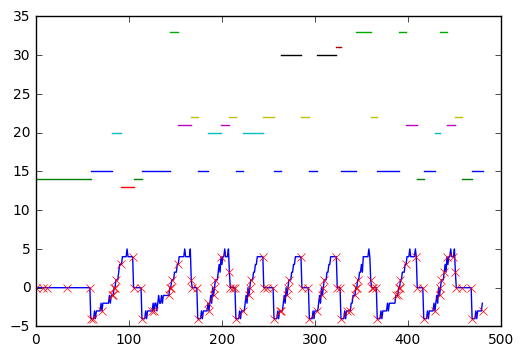

In [106]:
colors = ['r','g','b','c','m','y','k',"#aa0000","#00aa00","#0000aa","#880000","#008800","#000088"]
merged2color = {m:i for i,m in enumerate(sorted(merged))}

for m in merged:
    for t in merged[m]:
        plt.plot(np.array(path[t][1][2:4]),np.array([m,m])+10,colors[merged2color[m]])

plt.plot(velocities[:all_times[-1]])
plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
#plt.xlim((0,100))
plt.show()

# Interestingly, we have "on the ground for a litle bit" and "on the ground for longer" as different modes.

In [ ]:
start_time = 270
transitions = {}
# Edges into [outer] from [inner]
entries_from = {m: {m: [] for m in merged} 
                for m in merged}
# Edges into [outer]
entries = {m: [] for m in merged}
for t in range(1,len(path)):
    if t == 0:
        prev = -1
    else:
        prev = unions[t-1]

    start = path[t][1][2]
    entries_from[unions[t]][prev].append(start)
    entries[unions[t]].append(start)
    transitions[start] = (prev,unions[t])
    print (path[t][1][0],start),":",prev,"->",unions[t],"\n",path[unions[t]]

3 {'y_N': 3.9902605073215738, 'y_err': 0.45353490897011178, 'type': 'cN'}
4 {'type': 'c0', 'y_err': 8.5047659071813408e-155}
5 {'y_N': -4.029725724864508, 'y_acc': 0.11703164765546253, 'y_err': 0.43064157034662004, 'type': 'accN'}
10 {'type': 'accP', 'y_acc': 0.44012381237249515, 'y_err': 0.66918619530108148}
11 {'y_N': 3.6701622024362628, 'y_acc': 0.11430145052621844, 'y_err': 0.6515650896271068, 'type': 'accN'}
12 {'y_N': 0.99366058676183644, 'y_acc': -0.23890217503276545, 'y_err': 0.88376127247910952, 'type': 'accN'}
20 {'y_N': -2.699313917349643, 'y_acc': 0.38840032952514242, 'y_err': 0.6208499176336022, 'type': 'accN'}
21 {'type': 'c0', 'y_err': 2.3862329270201186}
23 {'type': 'acc0', 'y_acc': 0.35076700568347585, 'y_err': 0.66409901197535059}


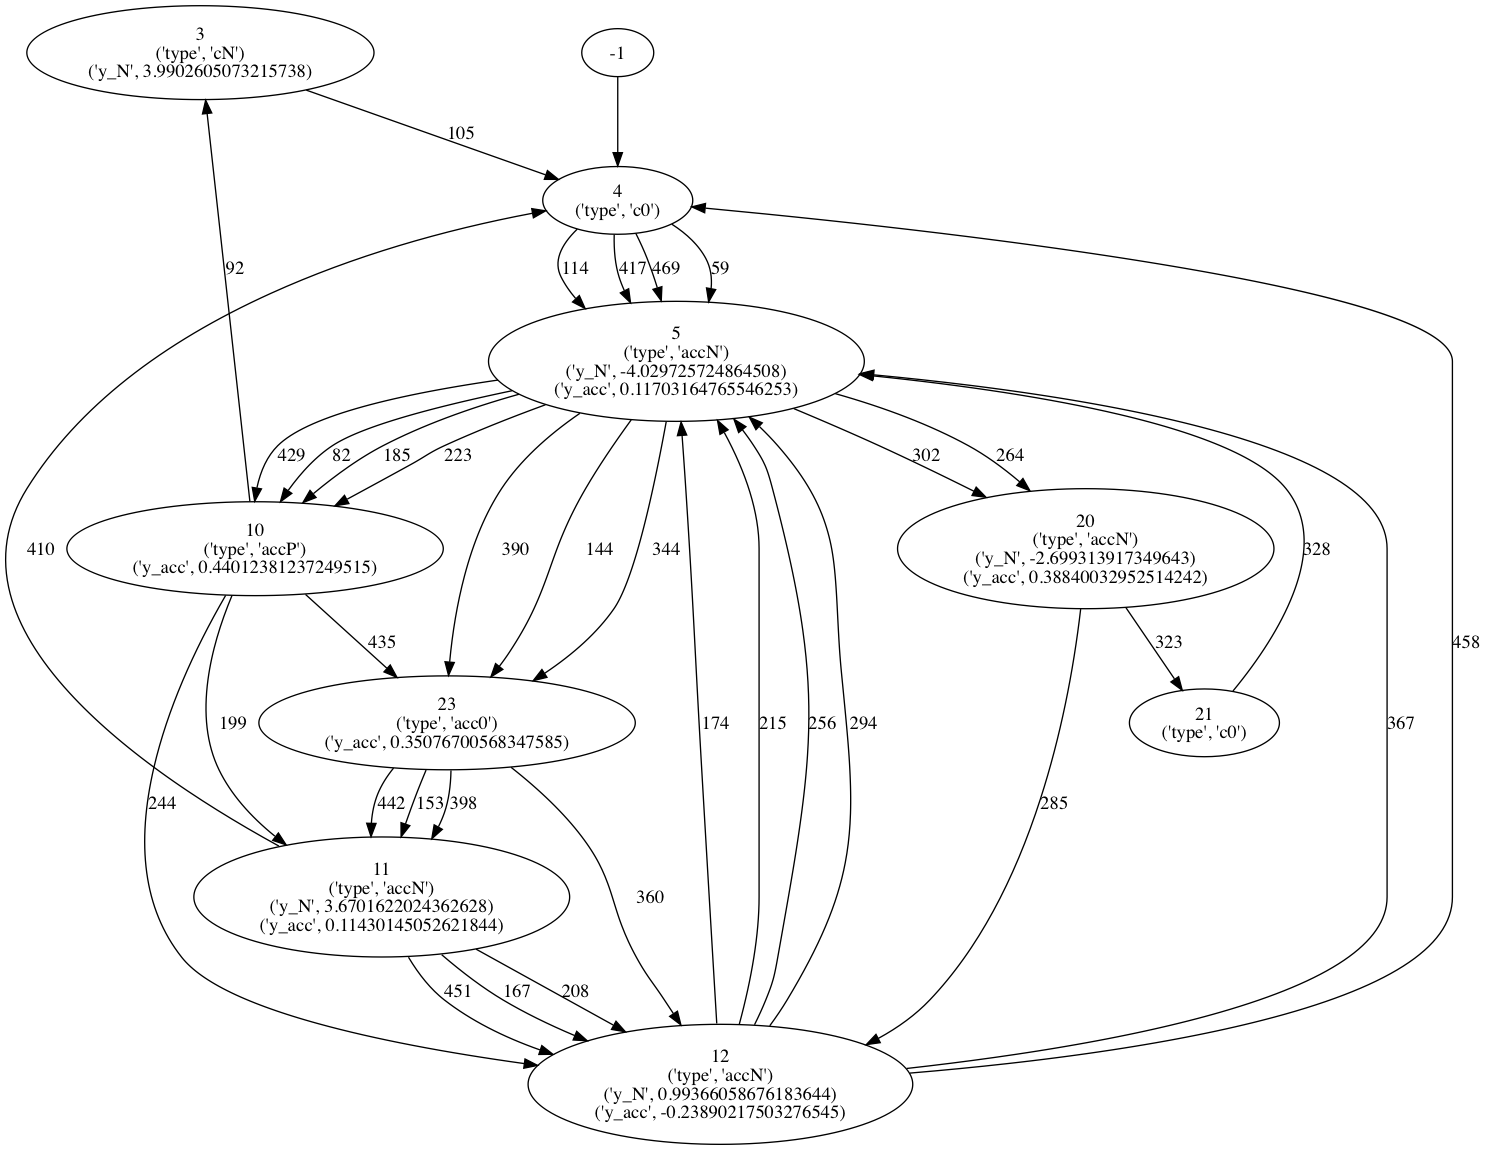

In [105]:
G = nx.MultiDiGraph()
for tgt,srcs in entries_from.items():
    G.add_node(tgt,label=str(tgt))
    # Let's learn about tgt
    mtype = path[tgt][1][4]
    params = path[tgt][1][5]["mean"].to_dict()
    params["type"] = mtype
    for k,v in sorted(params.items()):
        if k == "y_err":
            continue
        G.node[tgt]["label"] = (G.node[tgt]["label"] + "\n" + str((k,v)))
    print tgt,params
    for src,times in srcs.items():
        for t in times:
            G.add_edge(src,tgt,label=t)

G.add_node(-1)
G.add_edge(-1, unions[0])

nxpd.draw(G, show='ipynb')

In [22]:
collisions = pickle.load(open('mario_collisions.pkl'))

def button_changes(button_masks):
    last_mask = 0
    mask_times = {}
    for t, b in enumerate(button_masks):
        b_ = int(b)
        buttons = []
        for ii,c in enumerate(list('RLDUTSBA')):
            if b_ & (1 << (7-ii)):
                buttons.append(c)
        l_ = int(last_mask)
        last_buttons = []
        for ii,c in enumerate(list('RLDUTSBA')):
            if l_ & (1 << (7-ii)):
                last_buttons.append(c)
        mask_times[t] = (tuple(last_buttons),tuple(buttons))
        last_mask = b
    
    return mask_times

button_change_times = button_changes(inputVec)
for t in sorted(button_change_times):
    print t, button_change_times[t]

0 ((), ())
1 ((), ())
2 ((), ())
3 ((), ())
4 ((), ())
5 ((), ())
6 ((), ())
7 ((), ())
8 ((), ())
9 ((), ())
10 ((), ())
11 ((), ())
12 ((), ())
13 ((), ())
14 ((), ())
15 ((), ())
16 ((), ())
17 ((), ())
18 ((), ())
19 ((), ())
20 ((), ())
21 ((), ())
22 ((), ())
23 ((), ())
24 ((), ())
25 ((), ())
26 ((), ())
27 ((), ())
28 ((), ())
29 ((), ())
30 ((), ())
31 ((), ())
32 ((), ())
33 ((), ())
34 ((), ())
35 ((), ())
36 ((), ())
37 ((), ())
38 ((), ())
39 ((), ())
40 ((), ())
41 ((), ())
42 ((), ())
43 ((), ())
44 ((), ())
45 ((), ())
46 ((), ())
47 ((), ())
48 ((), ())
49 ((), ())
50 ((), ())
51 ((), ())
52 ((), ())
53 ((), ())
54 ((), ())
55 ((), ())
56 ((), ())
57 ((), ())
58 ((), ())
59 ((), ())
60 ((), ())
61 ((), ())
62 ((), ())
63 ((), ())
64 ((), ())
65 ((), ())
66 ((), ())
67 ((), ())
68 ((), ())
69 ((), ())
70 ((), ())
71 ((), ())
72 ((), ())
73 ((), ())
74 ((), ())
75 ((), ())
76 ((), ())
77 ((), ())
78 ((), ())
79 ((), ())
80 ((), ())
81 ((), ())
82 ((), ())
83 ((), ())
84

In [23]:
def sign(num):
    if num < 0:
        return -1
    if num > 0:
        return 1
    return 0

def button_diff(btnsA, btnsB):
    return set(btnsA) - set(btnsB)

def button_intersect(btnsA, btnsB):
    return set(btnsA) & set(btnsB)

def button_union(btnsA, btnsB):
    return set(btnsA) | set(btnsB)

def button_preds(button_pairs):
    here_i = set()
    for bp in button_pairs:
        released_i = button_diff(bp[0], bp[1])
        pressed_i = button_diff(bp[1], bp[0])    
        held_i = bp[1]
        for ri in released_i:
            here_i.add(("release",ri))
        for ri in pressed_i:
            here_i.add(("press",ri))
        for ri in held_i:
            here_i.add(("hold",ri))
    return list(here_i)

In [107]:
preds = [set()]*len(velocities)
for t in range(0,len(velocities)):
    psi = ([button_change_times[start_time+t+i]
            for i in range(0, 1)],
            #  TODO: stopped colliding/started colliding?  That would mean
           #   I could say "started colliding with X on bottom and also zin,-1"
           #   to help find solid things.
           #     ... no... acc,0 should be enough (walking right across solid tiles)
           #     but I should also consider 
           #     a more sophisticated notion of collision.
           #      e.g. "bottom" is good but it should be the lowest bottom tile.
           #      how can I get that?  can I get that?
           #      (OTOH, maybe this isn't even necessary if e.g. "touching my feet against sky"
          #        doesn't cause vy=0 as often as "touching my feet against ground" does. so let's be
          #         sure that's surfaced!)
            (collisions.get(start_time+t,set())),
            (velocities[t-1],velocities[t])
          )
    buttons_i = psi[0]
    here_i = button_preds(buttons_i)
    for coli in psi[1]:
        here_i.append(("col",coli))
    vel0,vel1 = psi[2]
    if vel0 < vel1:
        here_i.append(("acc",1))
    if vel0 > vel1:
        here_i.append(("acc",-1))
    if vel0 == vel1:
        here_i.append(("acc",0))
    if vel1 < 0:
        here_i.append(("vel",-1))
    if vel1 > 0:
        here_i.append(("vel",1))
    if vel1 == 0:
        here_i.append(("vel",0))
    if vel0 < 0 and vel1 > 0:
        here_i.append(("zc",1))
    if vel0 > 0 and vel1 < 0:
        here_i.append(("zc",-1))
    if vel0 < 0 and vel1 == 0:
        here_i.append(("zin",1))
    if vel0 > 0 and vel1 == 0:
        here_i.append(("zin",-1))
    if vel0 == 0 and vel1 < 0:
        here_i.append(("zout",-1))
    if vel0 == 0 and vel1 > 0:
        here_i.append(("zout",1))
    preds[t] = set(here_i)


Now, we need to use NPMI to figure out which conditions are likely to be important to the learned transitions.

In [108]:


def count_cooccurrences(pred_sets,ignored):
    ocs = {}
    coocs = {}
    nice_pred_sets = []
    for pi in range(0, len(pred_sets)):
        here_i = pred_sets[pi]
        here_i = list(set(here_i) - ignored)
        for pred in here_i:
            ocs[pred] = ocs.get(pred,0)+1
        for predii in range(0,len(here_i)):
            if here_i[predii] not in coocs:
                coocs[here_i[predii]] = {}
            for predij in range(0,len(here_i)):
                coocs[here_i[predii]][here_i[predij]] = coocs[here_i[predii]].get(here_i[predij],0)+1
        nice_pred_sets.append(here_i)
    return nice_pred_sets,ocs,coocs


def calc_npmi(pred_sets, ocs, coocs):
    maximum = float(len(pred_sets))
    npmis = {}
    probs = {}
    # How likely are individual predicates to co-occur 
    #  within the transitions to a given target?
    for predx,countx in ocs.items():
        px = countx / maximum
        probs[predx] = px
        for predy,countxy in coocs[predx].items():
            py = ocs[predy] / maximum
            pxy = countxy / maximum
            d = (math.log(px*py)/math.log(pxy) - 1) if pxy != 1 else 1
            npmis[(predx,predy)] = d
    return probs,npmis

def calc_npmi_pred_edge(all_ocs, all_edge_ocs, edge_count, all_edge_count):
    npmis = {}
    probs = {}
    # How likely are individual predicates to co-occur 
    #  within the transitions to a given target?
    for predx,countx in all_ocs.items():
        px = countx / float(all_edge_count)
        py = edge_count / float(all_edge_count)
        pxy = all_edge_ocs.get(predx,0) / float(all_edge_count)
        probs[predx] = all_edge_ocs.get(predx,0) / float(edge_count)
        assert px <= 1, (px,countx,all_edge_count)
        assert py <= 1, (py,edge_count,all_edge_count)
        assert pxy <= 1, (pxy,all_edge_ocs.get(predx,0),float(edge_count))
        if pxy == 0:
            d = -1
        elif pxy == 1:
            d = 1
        else:
            d = (math.log(px*py)/math.log(pxy) - 1)
        npmis[predx] = d
    return probs,npmis

def calc_npmi(pred1, pred2, all_counts, counts_by_time):
    norm = float(len(counts_by_time)+1)
    count1 = all_counts[pred1]
    count2 = all_counts[pred2]
    count12 = 0
    for t,cs in counts_by_time.items():
        count12 += cs.get(pred1,0) * cs.get(pred2,0)
    p1 = count1 / norm
    p2 = count2 / norm
    p12 = count12 / norm
    if p12 == 0:
        d = -1
    elif p12 == 1:
        d = 1
    else:
        d = math.log(p1*p2)/math.log(p12) - 1
    return d


In [114]:
def count_events(preds):
    all_counts = {}
    counts_by_time = {}
    for t,ps in enumerate(preds):
        counts_by_time[t] = {}
        for p in ps:
            all_counts[p] = all_counts.get(p,0)+1
            counts_by_time[t][p] = counts_by_time[t].get(p,0)+1
        if t in transitions:
            tr = transitions[t]
            key = ("tr",tr)
            all_counts[key] = all_counts.get(key,0)+1
            counts_by_time[t][key] = counts_by_time[t].get(key,0)+1
            (_,dest) = tr
            keystar = ("tr",("*",dest))
            all_counts[keystar] = all_counts.get(keystar,0)+1
            counts_by_time[t][keystar] = counts_by_time[t].get(keystar,0)+1
    return all_counts, counts_by_time

all_counts,counts_by_time = count_events(preds)

In [110]:
# Let's figure out which tiles block movement on which sides!
# co-occurrence of (col, BLAH) and acc0 for each BLAH.
# cluster together tiles which block on a given side (for now, all those with co-occurrence over threshold)
# then add new preds!

def cond_prob(e1, e2, all_counts, counts_by_time):
    p2 = all_counts[e2]/float(len(counts_by_time))
    count12 = 0
    for t,cs in counts_by_time.items():
        if (e1 in cs) and (e2 in cs):
            count12 += 1
    p12 = count12 / float(len(counts_by_time))
    return p12 / p2

block_chance = {}
for thing,count in all_counts.items():
    # TODO: generalize back to all sides, but note "colliding on right with something" -> "vely=0" is not that sensible.
    #  need a notion of acc,vel,zin,zout and _other axis_ acc,vel,zin,zout.
    if thing[0] != "col" or thing[1][1] != "bottom": 
        continue
    block_chance[thing] = cond_prob(("vel",0), 
                                    thing,
                                    all_counts,
                                    counts_by_time)

merged_by_side = {}
# TODO: generalize back to all sides
for side in ["bottom"]:
    blockings = filter(lambda (col,prob):(col[1][0][0] != "solid" and 
                                          col[1][1] == side and 
                                          prob > 0.8),
                       block_chance.items())
    merged_by_side[side] = set()
    for bcol,bprob in blockings:
        merged_by_side[side].add(bcol)
block_chance,merged_by_side

({('col', ((36, 0, 'tile'), 'bottom')): 0.20610687022900762,
  ('col', ((38, 0, 'tile'), 'bottom')): 0.7297297297297297,
  ('col', ((48, 0, 'tile'), 'bottom')): 0.5,
  ('col', ((49, 0, 'tile'), 'bottom')): 0.0,
  ('col', ((50, 0, 'tile'), 'bottom')): 0.0,
  ('col', ((51, 0, 'tile'), 'bottom')): 0.5714285714285714,
  ('col', ((52, 0, 'tile'), 'bottom')): 0.7777777777777779},
 {'bottom': set()})

In [118]:
# Let's add new preds now!
new_preds = [set() for i in range(0,len(preds))]
for t,pset in enumerate(preds):
    for side,equiv in merged_by_side.items():
        found = False
        for pred in pset:
            new_preds[t].add(pred)
            if not found and pred[0] == "col" and pred[1] in equiv:
                pset.append(("col", (("solid", equiv), side)))
                found = True
all_counts,counts_by_time = count_events(new_preds)

{('tr', ('*', 10)): 4, ('col', ((49, 0, 'tile'), 'bottom')): 10, ('col', ((38, 0, 'tile'), 'right')): 126, ('acc', -1): 68, ('press', 'A'): 14, ('tr', (5, 10)): 4, ('release', 'L'): 2, ('col', ((38, 0, 'tile'), 'internal')): 165, ('hold', 'L'): 44, ('tr', (11, 4)): 1, ('zin', 1): 15, ('tr', (4, 5)): 4, ('col', ((52, 0, 'tile'), 'left')): 69, ('col', ((52, 0, 'tile'), 'internal')): 93, ('col', ((49, 0, 'tile'), 'right')): 1, ('col', ((50, 0, 'tile'), 'bottom')): 12, ('col', ((48, 0, 'tile'), 'top')): 16, ('col', ((36, 0, 'tile'), 'left')): 345, ('zout', -1): 15, ('col', ((38, 0, 'tile'), 'top')): 77, ('tr', (21, 5)): 1, ('col', ((51, 0, 'tile'), 'left')): 57, ('tr', (10, 23)): 1, ('tr', (5, 20)): 2, ('tr', (10, 11)): 1, ('press', 'L'): 2, ('tr', (11, 12)): 3, ('acc', 0): 315, ('tr', (5, 23)): 3, ('tr', (10, 12)): 1, ('tr', ('*', 5)): 10, ('col', ((51, 0, 'tile'), 'internal')): 98, ('tr', ('*', 4)): 3, ('col', ((50, 0, 'tile'), 'left')): 8, ('col', ((49, 0, 'tile'), 'internal')): 37, ('c

In [119]:
# Let's calculate NPMI between predicates and transitions!
npmis = {}
for thing,count in all_counts.items():
    if thing[0] == "tr":
        print "tr:",thing,count
        tr = thing[1]
        # Find NPMI with every predicate
        for thing2,count in all_counts.items():
            if thing2[0] == "tr":
                continue
            if tr not in npmis:
                npmis[tr] = {}
            npmis[tr][thing2] = calc_npmi(thing, 
                                          thing2, 
                                          all_counts,
                                          counts_by_time)
    else:
        pass

for tr,prednpmis in npmis.items():
    print "----"
    print tr
    print "----"
    for pred,pmi in sorted(prednpmis.items(),
                           lambda a,b:sign(b[1]-a[1])):
        print pred,pmi

tr: ('tr', ('*', 10)) 4
tr: ('tr', (5, 10)) 4
tr: ('tr', (11, 4)) 1
tr: ('tr', (4, 5)) 4
tr: ('tr', (21, 5)) 1
tr: ('tr', (10, 23)) 1
tr: ('tr', (5, 20)) 2
tr: ('tr', (10, 11)) 1
tr: ('tr', (11, 12)) 3
tr: ('tr', (5, 23)) 3
tr: ('tr', (10, 12)) 1
tr: ('tr', ('*', 5)) 10
tr: ('tr', ('*', 4)) 3
tr: ('tr', ('*', 3)) 1
tr: ('tr', (10, 3)) 1
tr: ('tr', ('*', 12)) 6
tr: ('tr', ('*', 11)) 4
tr: ('tr', (23, 11)) 3
tr: ('tr', (12, 4)) 1
tr: ('tr', (12, 5)) 5
tr: ('tr', ('*', 23)) 4
tr: ('tr', ('*', 20)) 2
tr: ('tr', (23, 12)) 1
tr: ('tr', (3, 4)) 1
tr: ('tr', (20, 21)) 1
tr: ('tr', (20, 12)) 1
tr: ('tr', ('*', 21)) 1
----
(10, 11)
----
('press', 'L') 0.888464860602
('col', ((49, 0, 'tile'), 'top')) 0.510102263971
('col', ((50, 0, 'tile'), 'right')) 0.463810998634
('col', ((49, 0, 'tile'), 'internal')) 0.418962892678
('hold', 'L') 0.391081533383
('acc', 1) 0.235094133721
('vel', 1) 0.192663518382
('col', ((36, 0, 'tile'), 'top')) 0.0938749970008
('col', ((36, 0, 'tile'), 'left')) 0.0597082994638

In [120]:
def calc_npmi_chained(e1,e2,e3,all_counts,counts_by_time):
    p1 = all_counts[e1] / float(len(counts_by_time)+1)
    p2 = all_counts[e2] / float(len(counts_by_time)+1)
    if p1 == 0:
        assert(False)
        print "p1=0"
        return -1
    if p2 == 0:
        assert(False)
        print "p2=0"
        return -1
    count12 = 0
    for t,cs in counts_by_time.items():
        if (e1 in cs) and (e2 in cs):
            count12 += 1
    p12 = count12 / float(len(counts_by_time)+1)
    if p12 == 0:
        # Never co-occur, avoid log(0)
        return -1
    pmi12 = math.log(p12 / (p1 * p2))
    #p(event ,  causeB| causeA)/ (p(event) * p(causeB|causeA))
    times_1_and_3_and_2_happen = 0
    times_3_and_2_happen = 0
    times_any_happen = 0
    for t,cs in counts_by_time.items():
        if (e1 in cs) and (e3 in cs) and (e2 in cs):
            times_1_and_3_and_2_happen += 1
        if (e3 in cs) and (e2 in cs):
            times_3_and_2_happen += 1
        if (e1 in cs) or (e2 in cs) or (e3 in cs):
            times_any_happen += 1
    p132 = times_1_and_3_and_2_happen/float(len(counts_by_time)+1)
    if p132 == 0:
        # Never co-occur, avoid log(0)
        return -1
    p13_2 = (p132/p2)
    p32 = times_3_and_2_happen / float(len(counts_by_time)+1)
    p3_2 = p32/p2
    if p13_2 == 0:
        # Never co-occur, avoid log(0)
        return -1
    elif p3_2 == 0:
        # Never co-occur, avoid log(0)
        return -1
    pmi1_23 = math.log(p13_2/(p1 * p3_2))
    # normalize by log(p(event;causeA;causeB))??? no...
    # Normalize by self-information!
    return (pmi12 + pmi1_23)/(2*(-math.log(p132)))

# Let's calculate the NPMI of causal pairs with each transition!
paired_npmis = {}
for thing,count in all_counts.items():
    if thing[0] == "tr":
        print "tr:",thing,count
        tr = thing[1]
        if tr not in paired_npmis:
            paired_npmis[tr] = {}
        # Find NPMI with every predicate
        for thing2,count2 in all_counts.items():
            if thing2[0] == "tr":
                continue
            for thing3,count3 in all_counts.items():
                if thing3[0] == "tr" or thing3 == thing2:
                    continue
                key = (thing2,thing3)
                paired_npmis[tr][key] = calc_npmi_chained(thing,
                                                          thing2,
                                                          thing3,
                                                          all_counts,
                                                          counts_by_time)                
        print "\n".join(
            map(str,
                sorted(filter(
                        lambda (k,v): v > 0,
                        paired_npmis[tr].items()),
                       lambda a,b:sign(b[1]-a[1]))))
    else:
        pass



tr: ('tr', ('*', 10)) 4
((('press', 'L'), ('acc', 0)), 0.7211621515056089)
((('press', 'L'), ('vel', -1)), 0.7211621515056089)
((('press', 'L'), ('release', 'A')), 0.7211621515056089)
((('release', 'A'), ('vel', -1)), 0.6827915679842065)
((('press', 'L'), ('col', ((36, 0, 'tile'), 'right'))), 0.6653945818067307)
((('release', 'R'), ('col', ((36, 0, 'tile'), 'left'))), 0.6653945818067307)
((('press', 'L'), ('col', ((36, 0, 'tile'), 'bottom'))), 0.6653945818067307)
((('press', 'L'), ('col', ((36, 0, 'tile'), 'left'))), 0.6653945818067307)
((('release', 'R'), ('col', ((36, 0, 'tile'), 'top'))), 0.6653945818067307)
((('press', 'L'), ('col', ((36, 0, 'tile'), 'internal'))), 0.6653945818067307)
((('press', 'L'), ('col', ((36, 0, 'tile'), 'top'))), 0.6653945818067307)
((('press', 'L'), ('hold', 'L')), 0.6653945818067307)
((('release', 'A'), ('col', ((50, 0, 'tile'), 'right'))), 0.6589546980356319)
((('release', 'A'), ('col', ((48, 0, 'tile'), 'left'))), 0.6589546980356319)
((('release', 'A'),